<a href="https://colab.research.google.com/github/thc1006/coloran-dynamic-slice-optimizer/blob/main/%E7%B6%B2%E8%B7%AF%E5%88%87%E7%89%87%E8%B3%87%E6%BA%90%E5%8B%95%E6%85%8B%E5%88%86%E9%85%8D%E6%9C%80%E4%BD%B3%E5%8C%96v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* https://www.perplexity.ai/search/qing-bang-wo-zi-xi-fen-xi-zhe-uXuT4KoVSyCd3Xdj41mnFQ

### 1. 環境設置與資料載入

In [ ]:
# @title 下載 ColO-RAN 資料集到 Colab 檔案空間
import os
import subprocess

# 檢查並下載資料集
dataset_repo_url = "https://github.com/wineslab/colosseum-oran-coloran-dataset.git"
dataset_local_path = "/content/colosseum-oran-coloran-dataset"

print("開始下載 ColO-RAN 資料集...")
print(f"下載位置: {dataset_local_path}")

# 如果資料夾已存在，先刪除
if os.path.exists(dataset_local_path):
    print("發現現有資料夾，正在清理...")
    !rm -rf {dataset_local_path}

# Git clone 資料集
try:
    result = subprocess.run([
        "git", "clone", dataset_repo_url, dataset_local_path
    ], capture_output=True, text=True, timeout=600)

    if result.returncode == 0:
        print("✅ 資料集下載成功！")

        # 檢查下載的內容
        print("\n📁 資料集結構預覽：")
        !ls -la {dataset_local_path}

        # 檢查 rome_static_medium 資料夾
        rome_path = f"{dataset_local_path}/rome_static_medium"
        if os.path.exists(rome_path):
            print(f"\n✅ 找到 rome_static_medium 資料夾")
            !ls -la {rome_path}
        else:
            print(f"\n❌ 未找到 rome_static_medium 資料夾，列出所有內容：")
            !find {dataset_local_path} -type d -maxdepth 2

    else:
        print(f"❌ 下載失敗: {result.stderr}")

except subprocess.TimeoutExpired:
    print("❌ 下載超時，請檢查網路連線")
except Exception as e:
    print(f"❌ 下載過程中發生錯誤: {e}")

# 設定新的資料集路徑
DATASET_PATH = dataset_local_path
print(f"\n🎯 資料集路徑已設定為: {DATASET_PATH}")


開始下載 ColO-RAN 資料集...
下載位置: /content/colosseum-oran-coloran-dataset
✅ 資料集下載成功！

📁 資料集結構預覽：
total 68
drwxr-xr-x 4 root root  4096 Jul  3 23:55 .
drwxr-xr-x 1 root root  4096 Jul  3 23:54 ..
-rw-r--r-- 1 root root  1186 Jul  3 23:55 CITATION.cff
drwxr-xr-x 8 root root  4096 Jul  3 23:56 .git
-rw-r--r-- 1 root root    36 Jul  3 23:55 .gitignore
-rw-r--r-- 1 root root 35149 Jul  3 23:55 LICENSE
-rw-r--r-- 1 root root  5426 Jul  3 23:55 README.md
drwxr-xr-x 5 root root  4096 Jul  3 23:56 rome_static_medium

✅ 找到 rome_static_medium 資料夾
total 20
drwxr-xr-x  5 root root 4096 Jul  3 23:56 .
drwxr-xr-x  4 root root 4096 Jul  3 23:55 ..
drwxr-xr-x 30 root root 4096 Jul  3 23:56 sched0
drwxr-xr-x 30 root root 4096 Jul  3 23:56 sched1
drwxr-xr-x 30 root root 4096 Jul  3 23:56 sched2

🎯 資料集路徑已設定為: /content/colosseum-oran-coloran-dataset


### 2. 資料集載入與整合函數

In [ ]:
# @title 完整版 ColO-RAN 資料處理器（載入全部 588 個組合）
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

class ColoRANDataProcessorPro:
    def __init__(self, dataset_path):
        self.dataset_path = dataset_path
        self.base_stations = [1, 8, 15, 22, 29, 36, 43]
        self.scheduling_policies = ['sched0', 'sched1', 'sched2']  # RR, WF, PF

        # 全部 28 個訓練配置 - 不再限制記憶體
        self.training_configs = [f'tr{i}' for i in range(28)]

        # 切片配置定義（完整版）
        self.slice_configs = {
            'tr0': [2, 13, 2], 'tr1': [4, 11, 2], 'tr2': [6, 9, 2], 'tr3': [8, 7, 2],
            'tr4': [10, 5, 2], 'tr5': [12, 3, 2], 'tr6': [14, 1, 2], 'tr7': [2, 11, 4],
            'tr8': [4, 9, 4], 'tr9': [6, 7, 4], 'tr10': [8, 5, 4], 'tr11': [10, 3, 4],
            'tr12': [12, 1, 4], 'tr13': [2, 9, 6], 'tr14': [4, 7, 6], 'tr15': [6, 5, 6],
            'tr16': [8, 3, 6], 'tr17': [10, 1, 6], 'tr18': [2, 7, 8], 'tr19': [4, 5, 8],
            'tr20': [6, 3, 8], 'tr21': [8, 1, 8], 'tr22': [2, 5, 10], 'tr23': [4, 3, 10],
            'tr24': [6, 1, 10], 'tr25': [2, 3, 12], 'tr26': [4, 1, 12], 'tr27': [2, 1, 14]
        }

        print(f"🚀 初始化 ColO-RAN Pro 處理器")
        print(f"📁 資料集路徑: {self.dataset_path}")
        print(f"🎯 目標配置: 全部 {len(self.training_configs)} 個配置")
        print(f"📊 預計載入組合數: {len(self.scheduling_policies)} × {len(self.training_configs)} × {len(self.base_stations)} = {len(self.scheduling_policies) * len(self.training_configs) * len(self.base_stations)}")

    def auto_detect_structure(self):
        """自動偵測資料集結構"""
        print("🔍 自動偵測資料集結構...")

        # 可能的路徑結構
        possible_paths = [
            f"{self.dataset_path}/rome_static_medium",
            f"{self.dataset_path}/colosseum-oran-coloran-dataset/rome_static_medium",
            self.dataset_path
        ]

        for path in possible_paths:
            if os.path.exists(path):
                sched_dirs = [d for d in os.listdir(path) if d.startswith('sched')]
                if sched_dirs:
                    print(f"✅ 找到有效結構: {path}")
                    print(f"📂 發現排程策略: {sched_dirs}")
                    return path

        print("❌ 未找到標準資料結構，列出可用目錄：")
        if os.path.exists(self.dataset_path):
            for item in os.listdir(self.dataset_path):
                print(f"  - {item}")

        return self.dataset_path

    def load_all_data_with_glob_pro(self):
        """使用 glob 載入全部資料（Pro 版本，無記憶體限制）"""

        # 自動偵測資料結構
        base_data_path = self.auto_detect_structure()

        bs_data_list = []
        ue_data_list = []
        slice_data_list = []

        total_combinations = len(self.scheduling_policies) * len(self.training_configs) * len(self.base_stations)
        current = 0
        success_count = 0

        print("\n" + "="*80)
        print("🚀 開始載入完整 ColO-RAN 資料集（全部 588 個組合）")
        print("="*80)

        for sched_policy in self.scheduling_policies:
            for training_config in self.training_configs:
                print(f"\n📋 處理配置: {sched_policy}/{training_config}")

                # 建構搜尋路徑
                search_patterns = {
                    'bs': f"{base_data_path}/{sched_policy}/{training_config}/exp*/bs*/bs*.csv",
                    'ue': f"{base_data_path}/{sched_policy}/{training_config}/exp*/bs*/ue*.csv",
                    'slice': f"{base_data_path}/{sched_policy}/{training_config}/exp*/bs*/slices_bs*/*_metrics.csv"
                }

                # 載入 BS 資料
                bs_files = glob.glob(search_patterns['bs'])
                print(f"  📊 BS 檔案: {len(bs_files)} 個")

                for bs_file in bs_files:
                    current += 1
                    try:
                        df = pd.read_csv(bs_file)

                        # 解析路徑資訊
                        path_parts = bs_file.split('/')
                        exp_folder = next((p for p in path_parts if p.startswith('exp')), 'exp1')
                        bs_folder = next((p for p in path_parts if p.startswith('bs') and not p.endswith('.csv')), 'bs1')

                        bs_id = int(bs_folder.replace('bs', ''))
                        exp_id = int(exp_folder.replace('exp', ''))

                        # 添加 metadata
                        df['bs_id'] = bs_id
                        df['exp_id'] = exp_id
                        df['sched_policy'] = sched_policy
                        df['training_config'] = training_config
                        df['file_path'] = bs_file

                        bs_data_list.append(df)
                        success_count += 1

                        if current % 50 == 0:
                            print(f"    ⏳ 進度: {current}/{total_combinations} ({current/total_combinations*100:.1f}%)")

                    except Exception as e:
                        print(f"    ❌ BS 檔案載入失敗 {bs_file}: {e}")

                # 載入 UE 資料
                ue_files = glob.glob(search_patterns['ue'])
                print(f"  📱 UE 檔案: {len(ue_files)} 個")

                for ue_file in ue_files:
                    try:
                        df = pd.read_csv(ue_file)

                        # 解析路徑資訊
                        path_parts = ue_file.split('/')
                        exp_folder = next((p for p in path_parts if p.startswith('exp')), 'exp1')
                        bs_folder = next((p for p in path_parts if p.startswith('bs') and not p.endswith('.csv')), 'bs1')
                        ue_file_name = os.path.basename(ue_file)

                        bs_id = int(bs_folder.replace('bs', ''))
                        exp_id = int(exp_folder.replace('exp', ''))
                        ue_id = int(ue_file_name.replace('ue', '').replace('.csv', ''))

                        # 添加 metadata
                        df['bs_id'] = bs_id
                        df['exp_id'] = exp_id
                        df['ue_id'] = ue_id
                        df['sched_policy'] = sched_policy
                        df['training_config'] = training_config
                        df['file_path'] = ue_file

                        ue_data_list.append(df)

                    except Exception as e:
                        print(f"    ❌ UE 檔案載入失敗 {ue_file}: {e}")

                # 載入 Slice 資料
                slice_files = glob.glob(search_patterns['slice'])
                print(f"  🍰 Slice 檔案: {len(slice_files)} 個")

                for slice_file in slice_files:
                    try:
                        df = pd.read_csv(slice_file)

                        # 解析路徑資訊
                        path_parts = slice_file.split('/')
                        exp_folder = next((p for p in path_parts if p.startswith('exp')), 'exp1')
                        bs_folder = next((p for p in path_parts if p.startswith('bs') and 'slices' not in p), 'bs1')
                        slice_file_name = os.path.basename(slice_file)

                        bs_id = int(bs_folder.replace('bs', ''))
                        exp_id = int(exp_folder.replace('exp', ''))
                        imsi = slice_file_name.replace('_metrics.csv', '')

                        # 添加 metadata
                        df['bs_id'] = bs_id
                        df['exp_id'] = exp_id
                        df['imsi'] = imsi
                        df['sched_policy'] = sched_policy
                        df['training_config'] = training_config
                        df['file_path'] = slice_file

                        slice_data_list.append(df)

                    except Exception as e:
                        print(f"    ❌ Slice 檔案載入失敗 {slice_file}: {e}")

        # 合併所有資料
        print("\n" + "="*80)
        print("🔗 合併資料中...")

        combined_bs_data = pd.concat(bs_data_list, ignore_index=True) if bs_data_list else None
        combined_ue_data = pd.concat(ue_data_list, ignore_index=True) if ue_data_list else None
        combined_slice_data = pd.concat(slice_data_list, ignore_index=True) if slice_data_list else None

        # 記憶體使用情況
        def get_memory_usage(df, name):
            if df is not None:
                memory_mb = df.memory_usage(deep=True).sum() / 1024 / 1024
                return f"{name}: {len(df):,} 筆記錄, {memory_mb:.1f} MB"
            return f"{name}: 0 筆記錄"

        print("\n" + "="*80)
        print("📊 載入完成統計")
        print("="*80)
        print(get_memory_usage(combined_bs_data, "基站資料"))
        print(get_memory_usage(combined_ue_data, "UE資料"))
        print(get_memory_usage(combined_slice_data, "切片資料"))
        print(f"✅ 成功載入檔案數: {success_count}")
        print(f"🎯 載入成功率: {success_count/total_combinations*100:.1f}%")

        return combined_bs_data, combined_ue_data, combined_slice_data

# 執行完整載入
processor_pro = ColoRANDataProcessorPro(DATASET_PATH)
bs_data_full, ue_data_full, slice_data_full = processor_pro.load_all_data_with_glob_pro()

# 顯示載入結果摘要
print("\n" + "🎉" + "="*78 + "🎉")
print("ColO-RAN 完整資料集載入完成！")
print("="*80)

if bs_data_full is not None:
    print(f"📊 基站資料: {len(bs_data_full):,} 筆記錄")
    print(f"   排程策略分佈: {bs_data_full['sched_policy'].value_counts().to_dict()}")
    print(f"   訓練配置數量: {bs_data_full['training_config'].nunique()}")
    print(f"   基站數量: {bs_data_full['bs_id'].nunique()}")

if ue_data_full is not None:
    print(f"📱 UE資料: {len(ue_data_full):,} 筆記錄")
    print(f"   UE設備數量: {ue_data_full['ue_id'].nunique()}")

if slice_data_full is not None:
    print(f"🍰 切片資料: {len(slice_data_full):,} 筆記錄")
    print(f"   IMSI數量: {slice_data_full['imsi'].nunique()}")

print("\n🚀 資料集已準備完成，可進行後續分析！")

# ===== 在 Cell 2 最後加入以下程式碼 =====

# 保存原始載入的資料為 parquet 檔案
def save_raw_data_to_parquet():
    """將載入的原始資料保存為 parquet 檔案"""
    print("\n" + "💾" + "="*78 + "💾")
    print("保存原始資料為 Parquet 檔案")
    print("="*80)

    saved_files = []

    # 保存基站資料
    if bs_data_full is not None and len(bs_data_full) > 0:
        bs_filename = 'raw_bs_data.parquet'
        bs_data_full.to_parquet(bs_filename, compression='snappy', index=False)
        file_size = os.path.getsize(bs_filename) / 1024 / 1024
        print(f"✅ 基站資料已保存: {bs_filename} ({file_size:.1f} MB)")
        saved_files.append(bs_filename)

    # 保存 UE 資料
    if ue_data_full is not None and len(ue_data_full) > 0:
        ue_filename = 'raw_ue_data.parquet'
        ue_data_full.to_parquet(ue_filename, compression='snappy', index=False)
        file_size = os.path.getsize(ue_filename) / 1024 / 1024
        print(f"✅ UE資料已保存: {ue_filename} ({file_size:.1f} MB)")
        saved_files.append(ue_filename)

    # 保存切片資料
    if slice_data_full is not None and len(slice_data_full) > 0:
        slice_filename = 'raw_slice_data.parquet'
        slice_data_full.to_parquet(slice_filename, compression='snappy', index=False)
        file_size = os.path.getsize(slice_filename) / 1024 / 1024
        print(f"✅ 切片資料已保存: {slice_filename} ({file_size:.1f} MB)")
        saved_files.append(slice_filename)

    # 保存切片配置資訊
    import json
    config_filename = 'slice_configs.json'
    with open(config_filename, 'w') as f:
        json.dump(processor_pro.slice_configs, f, indent=2)
    print(f"✅ 切片配置已保存: {config_filename}")
    saved_files.append(config_filename)

    print(f"\n🎉 所有原始資料已成功保存！")
    print(f"📁 保存檔案清單: {saved_files}")
    print(f"💡 下次可直接從 Cell 3 開始執行，自動載入這些檔案")

    return saved_files

# 執行保存
saved_files = save_raw_data_to_parquet()



🚀 初始化 ColO-RAN Pro 處理器
📁 資料集路徑: /content/colosseum-oran-coloran-dataset
🎯 目標配置: 全部 28 個配置
📊 預計載入組合數: 3 × 28 × 7 = 588
🔍 自動偵測資料集結構...
✅ 找到有效結構: /content/colosseum-oran-coloran-dataset/rome_static_medium
📂 發現排程策略: ['sched1', 'sched0', 'sched2']

🚀 開始載入完整 ColO-RAN 資料集（全部 588 個組合）

📋 處理配置: sched0/tr0
  📊 BS 檔案: 35 個
  📱 UE 檔案: 210 個
  🍰 Slice 檔案: 206 個

📋 處理配置: sched0/tr1
  📊 BS 檔案: 35 個
    ⏳ 進度: 50/588 (8.5%)
  📱 UE 檔案: 209 個
  🍰 Slice 檔案: 206 個

📋 處理配置: sched0/tr2
  📊 BS 檔案: 35 個
    ⏳ 進度: 100/588 (17.0%)
  📱 UE 檔案: 209 個
  🍰 Slice 檔案: 205 個

📋 處理配置: sched0/tr3
  📊 BS 檔案: 35 個
  📱 UE 檔案: 210 個
  🍰 Slice 檔案: 206 個

📋 處理配置: sched0/tr4
  📊 BS 檔案: 35 個
    ⏳ 進度: 150/588 (25.5%)
  📱 UE 檔案: 210 個
  🍰 Slice 檔案: 206 個

📋 處理配置: sched0/tr5
  📊 BS 檔案: 35 個
    ⏳ 進度: 200/588 (34.0%)
  📱 UE 檔案: 210 個
  🍰 Slice 檔案: 203 個

📋 處理配置: sched0/tr6
  📊 BS 檔案: 35 個
  📱 UE 檔案: 210 個
  🍰 Slice 檔案: 205 個

📋 處理配置: sched0/tr7
  📊 BS 檔案: 35 個
    ⏳ 進度: 250/588 (42.5%)
  📱 UE 檔案: 210 個
  🍰 Slice 檔案: 206 個

📋 處理配置: s

### 3. 資料前處理與特徵工程

In [ ]:
# @title 記憶體優化特徵工程處理器（含自動檢查點讀取與分批處理）
import pandas as pd
import numpy as np
import gc
from datetime import datetime
import os
import json
import warnings
warnings.filterwarnings('ignore')

def load_raw_data_if_exists():
    """檢查並載入已保存的原始資料"""
    print("🔍 檢查是否存在已保存的原始資料...")

    # 檢查必要檔案是否存在
    required_files = [
        'raw_bs_data.parquet',
        'raw_ue_data.parquet',
        'raw_slice_data.parquet',
        'slice_configs.json'
    ]

    missing_files = [f for f in required_files if not os.path.exists(f)]

    if missing_files:
        print(f"❌ 缺少檔案: {missing_files}")
        print("💡 請先執行 Cell 2 載入原始資料")
        return None, None, None, None

    print("✅ 找到所有必要檔案，開始載入...")

    try:
        # 載入資料
        bs_data = pd.read_parquet('raw_bs_data.parquet')
        ue_data = pd.read_parquet('raw_ue_data.parquet')
        slice_data = pd.read_parquet('raw_slice_data.parquet')

        # 載入配置
        with open('slice_configs.json', 'r') as f:
            slice_configs = json.load(f)

        print(f"✅ 資料載入完成！")
        print(f"   📊 基站資料: {len(bs_data):,} 筆記錄")
        print(f"   📱 UE資料: {len(ue_data):,} 筆記錄")
        print(f"   🍰 切片資料: {len(slice_data):,} 筆記錄")
        print(f"   ⚙️ 切片配置: {len(slice_configs)} 個")

        return bs_data, ue_data, slice_data, slice_configs

    except Exception as e:
        print(f"❌ 載入資料時發生錯誤: {e}")
        return None, None, None, None

class MemoryOptimizedNetworkSliceProcessor:
    def __init__(self, slice_configs, batch_size=100000):
        self.slice_configs = slice_configs
        self.batch_size = batch_size
        self.processed_batches = []

        print(f"🔧 初始化記憶體優化處理器")
        print(f"📦 批次大小: {self.batch_size:,} 筆記錄")

    def process_data_in_batches(self, slice_data):
        """分批處理大型資料集"""
        print(f"🚀 開始分批處理，總記錄數: {len(slice_data):,}")

        total_rows = len(slice_data)
        num_batches = (total_rows + self.batch_size - 1) // self.batch_size

        processed_results = []

        for batch_idx in range(num_batches):
            start_idx = batch_idx * self.batch_size
            end_idx = min((batch_idx + 1) * self.batch_size, total_rows)

            print(f"  📦 處理批次 {batch_idx + 1}/{num_batches} ({start_idx:,}-{end_idx:,})")

            # 取得當前批次資料
            batch_data = slice_data.iloc[start_idx:end_idx].copy()

            # 處理當前批次
            processed_batch = self._process_single_batch(batch_data)

            if processed_batch is not None:
                processed_results.append(processed_batch)
                print(f"    ✅ 批次處理完成: {len(processed_batch):,} 筆記錄")

            # 立即釋放記憶體
            del batch_data, processed_batch
            gc.collect()

            # 顯示記憶體使用狀況
            if (batch_idx + 1) % 5 == 0:
                memory_info = self._get_memory_info()
                print(f"    💾 記憶體使用: {memory_info}")

        # 合併所有批次結果
        if processed_results:
            print("🔗 合併所有批次結果...")
            final_result = pd.concat(processed_results, ignore_index=True)

            # 清理中間結果
            del processed_results
            gc.collect()

            return final_result

        return None

    def _process_single_batch(self, df):
        """處理單一批次的資料"""
        try:
            # 1. 時間特徵（向量化）
            if 'Timestamp' in df.columns:
                timestamps = pd.to_datetime(df['Timestamp'], unit='ms', errors='coerce')
                df['hour'] = timestamps.dt.hour
                df['minute'] = timestamps.dt.minute
                df['day_of_week'] = timestamps.dt.dayofweek
                # 不保留完整的 timestamp 欄位以節省記憶體
                del timestamps

            # 2. 排程策略編碼（向量化）
            sched_mapping = {'sched0': 0, 'sched1': 1, 'sched2': 2}
            df['sched_policy_num'] = df['sched_policy'].map(sched_mapping)

            # 3. RBG 配置（向量化優化）
            df['allocated_rbgs'] = self._vectorized_rbg_allocation(df)

            # 4. 資源利用率（向量化）
            df['sum_requested_prbs'] = df.get('sum_requested_prbs', 0).fillna(0)
            df['sum_granted_prbs'] = df.get('sum_granted_prbs', 0).fillna(0)
            df['prb_utilization'] = np.where(
                df['sum_requested_prbs'] > 0,
                df['sum_granted_prbs'] / df['sum_requested_prbs'],
                0
            ).clip(0, 1)

            # 5. 吞吐量效率（向量化）
            throughput_col = 'tx_brate downlink [Mbps]'
            if throughput_col in df.columns:
                df['throughput_efficiency'] = np.where(
                    df['sum_granted_prbs'] > 0,
                    df[throughput_col].fillna(0) / df['sum_granted_prbs'],
                    0
                )
            else:
                df['throughput_efficiency'] = 0.0

            # 6. QoS 評分（向量化）
            df['qos_score'] = self._calculate_qos_score_vectorized(df)

            # 7. 網路負載
            df['num_ues'] = df.get('num_ues', 1).fillna(1)
            df['network_load'] = df['num_ues'] / 42.0

            # 8. 綜合效率指標
            df['allocation_efficiency'] = (
                0.5 * df['throughput_efficiency'] +
                0.3 * df['qos_score'] +
                0.2 * df['prb_utilization']
            ).clip(0, 1)

            # 9. 選擇需要的欄位，移除不必要的欄位
            required_columns = [
                'num_ues', 'slice_id', 'sched_policy_num', 'allocated_rbgs',
                'bs_id', 'exp_id', 'sum_requested_prbs', 'sum_granted_prbs',
                'prb_utilization', 'throughput_efficiency', 'qos_score',
                'network_load', 'hour', 'minute', 'day_of_week',
                'allocation_efficiency', 'sched_policy', 'training_config'
            ]

            available_columns = [col for col in required_columns if col in df.columns]
            df_result = df[available_columns].copy()

            # 清理異常值
            df_result = df_result.dropna(subset=['allocation_efficiency'])

            return df_result

        except Exception as e:
            print(f"    ❌ 批次處理失敗: {e}")
            return None

    def _vectorized_rbg_allocation(self, df):
        """向量化的 RBG 配置計算"""
        # 創建配置對應字典
        config_map = {}
        for config_name, rbg_list in self.slice_configs.items():
            for slice_id in range(len(rbg_list)):
                config_map[(config_name, slice_id)] = rbg_list[slice_id]

        # 向量化映射
        allocation_keys = list(zip(df['training_config'], df.get('slice_id', 0).fillna(0)))
        return pd.Series(allocation_keys).map(config_map).fillna(0).values

    def _calculate_qos_score_vectorized(self, df):
        """向量化的 QoS 評分計算"""
        dl_error_col = 'tx_errors downlink (%)'
        ul_error_col = 'rx_errors uplink (%)'
        cqi_col = 'dl_cqi'

        dl_score = 0.5  # 預設值
        ul_score = 0.5  # 預設值
        cqi_score = 0.5  # 預設值

        if dl_error_col in df.columns:
            dl_score = (100 - df[dl_error_col].fillna(50)) / 100

        if ul_error_col in df.columns:
            ul_score = (100 - df[ul_error_col].fillna(50)) / 100

        if cqi_col in df.columns:
            cqi_score = df[cqi_col].fillna(7.5) / 15

        return (0.4 * dl_score + 0.3 * ul_score + 0.3 * cqi_score).clip(0, 1)

    def _get_memory_info(self):
        """取得記憶體使用資訊"""
        try:
            import psutil
            process = psutil.Process()
            memory_mb = process.memory_info().rss / 1024 / 1024
            return f"{memory_mb:.1f} MB"
        except:
            return "無法取得"

def optimize_datatypes(df):
    """最佳化資料型別以節省記憶體"""
    print("🔧 最佳化資料型別...")

    initial_memory = df.memory_usage(deep=True).sum() / 1024 / 1024

    # 整數型別最佳化
    int_cols = df.select_dtypes(include=['int64']).columns
    for col in int_cols:
        col_min, col_max = df[col].min(), df[col].max()
        if col_min >= 0 and col_max < 255:
            df[col] = df[col].astype('uint8')
        elif col_min >= 0 and col_max < 65535:
            df[col] = df[col].astype('uint16')
        elif col_min >= -128 and col_max < 127:
            df[col] = df[col].astype('int8')
        elif col_min >= -32768 and col_max < 32767:
            df[col] = df[col].astype('int16')

    # 浮點數型別最佳化
    float_cols = df.select_dtypes(include=['float64']).columns
    for col in float_cols:
        df[col] = pd.to_numeric(df[col], downcast='float')

    # 類別型資料
    object_cols = df.select_dtypes(include=['object']).columns
    for col in object_cols:
        if df[col].nunique() / len(df) < 0.5:
            df[col] = df[col].astype('category')

    final_memory = df.memory_usage(deep=True).sum() / 1024 / 1024
    print(f"  💾 記憶體最佳化: {initial_memory:.1f} MB → {final_memory:.1f} MB")
    print(f"  📉 節省: {((initial_memory - final_memory) / initial_memory * 100):.1f}%")

    return df

def save_processed_data_to_parquet(processed_data, feature_names):
    """保存處理後的資料為 Parquet 格式"""
    if processed_data is None or len(processed_data) == 0:
        print("❌ 沒有資料可儲存")
        return None

    print(f"\n💾 保存處理後的資料...")

    # 最佳化資料型別
    optimized_data = optimize_datatypes(processed_data.copy())

    # 保存為 Parquet
    output_filename = 'coloran_processed_features.parquet'
    optimized_data.to_parquet(
        output_filename,
        compression='snappy',
        index=False,
        engine='pyarrow'
    )

    # 計算檔案大小
    file_size = os.path.getsize(output_filename) / 1024 / 1024
    memory_size = optimized_data.memory_usage(deep=True).sum() / 1024 / 1024

    print(f"✅ 特徵資料已保存: {output_filename}")
    print(f"📊 記錄數量: {len(optimized_data):,}")
    print(f"📋 特徵數量: {len(feature_names)}")
    print(f"💾 檔案大小: {file_size:.1f} MB")
    print(f"🗜️ 壓縮效率: {memory_size/file_size:.1f}x")

    # 保存特徵名稱和元資料
    feature_info = {
        'feature_names': feature_names,
        'total_records': len(optimized_data),
        'processing_date': datetime.now().isoformat(),
        'file_size_mb': file_size,
        'compression_ratio': memory_size/file_size
    }

    with open('feature_metadata.json', 'w') as f:
        json.dump(feature_info, f, indent=2)

    print(f"📋 特徵元資料已保存: feature_metadata.json")

    # 清理記憶體
    del optimized_data
    gc.collect()

    return output_filename

def main_processing_pipeline():
    """主要處理管道"""
    print("🚀 啟動記憶體優化特徵工程管道")
    print("="*60)

    # 1. 載入原始資料
    bs_data_loaded, ue_data_loaded, slice_data_loaded, slice_configs_loaded = load_raw_data_if_exists()

    # 如果無法載入保存的檔案，則嘗試使用 Cell 2 的變數
    if slice_data_loaded is None:
        print("⚠️ 嘗試使用 Cell 2 的記憶體變數...")
        if 'bs_data_full' in globals():
            bs_data_loaded = bs_data_full
            ue_data_loaded = ue_data_full
            slice_data_loaded = slice_data_full
            slice_configs_loaded = processor_pro.slice_configs
            print("✅ 成功使用 Cell 2 的記憶體資料")
        else:
            print("❌ 請先執行 Cell 2 載入資料")
            return None, None

    if slice_data_loaded is None or len(slice_data_loaded) == 0:
        print("❌ 無可用的切片資料")
        return None, None

    # 2. 初始化記憶體優化處理器
    print(f"\n🔧 初始化處理器...")
    processor = MemoryOptimizedNetworkSliceProcessor(
        slice_configs_loaded,
        batch_size=75000  # 根據 83.5 GB RAM 調整的批次大小
    )

    # 3. 分批處理資料
    print(f"\n📊 開始分批特徵工程...")
    start_time = datetime.now()

    processed_data = processor.process_data_in_batches(slice_data_loaded)

    end_time = datetime.now()
    processing_time = (end_time - start_time).total_seconds()

    if processed_data is None:
        print("❌ 特徵工程處理失敗")
        return None, None

    # 4. 立即清理原始資料以釋放記憶體
    del bs_data_loaded, ue_data_loaded, slice_data_loaded
    gc.collect()

    print(f"✅ 特徵工程完成!")
    print(f"⏱️ 處理時間: {processing_time:.2f} 秒")
    print(f"📊 最終記錄數: {len(processed_data):,}")

    # 5. 建立特徵列表
    feature_columns = [
        'num_ues', 'slice_id', 'sched_policy_num', 'allocated_rbgs',
        'bs_id', 'exp_id', 'sum_requested_prbs', 'sum_granted_prbs',
        'prb_utilization', 'throughput_efficiency', 'qos_score',
        'network_load', 'hour', 'minute', 'day_of_week'
    ]

    available_features = [f for f in feature_columns if f in processed_data.columns]

    print(f"\n📋 可用特徵 ({len(available_features)} 個):")
    for i, feature in enumerate(available_features, 1):
        print(f"  {i:2d}. {feature}")

    # 6. 保存處理後的資料
    saved_file = save_processed_data_to_parquet(processed_data, available_features)

    # 7. 顯示統計資訊
    if 'allocation_efficiency' in processed_data.columns:
        print(f"\n📈 目標變數統計:")
        stats = processed_data['allocation_efficiency'].describe()
        print(f"   平均: {stats['mean']:.4f}")
        print(f"   標準差: {stats['std']:.4f}")
        print(f"   範圍: {stats['min']:.4f} - {stats['max']:.4f}")

    print(f"\n🎉 Cell 3 執行完成！")
    print(f"📁 輸出檔案: {saved_file}")
    print(f"💡 下一步: 執行 Cell 4 進行機器學習訓練")

    return processed_data, available_features

# 執行主要處理管道
processed_data_full, feature_names_full = main_processing_pipeline()


🚀 啟動記憶體優化特徵工程管道
🔍 檢查是否存在已保存的原始資料...
✅ 找到所有必要檔案，開始載入...
✅ 資料載入完成！
   📊 基站資料: 6,534,544 筆記錄
   📱 UE資料: 36,974,950 筆記錄
   🍰 切片資料: 35,512,393 筆記錄
   ⚙️ 切片配置: 28 個

🔧 初始化處理器...
🔧 初始化記憶體優化處理器
📦 批次大小: 75,000 筆記錄

📊 開始分批特徵工程...
🚀 開始分批處理，總記錄數: 35,512,393
  📦 處理批次 1/474 (0-75,000)
    ✅ 批次處理完成: 75,000 筆記錄
  📦 處理批次 2/474 (75,000-150,000)
    ✅ 批次處理完成: 75,000 筆記錄
  📦 處理批次 3/474 (150,000-225,000)
    ✅ 批次處理完成: 75,000 筆記錄
  📦 處理批次 4/474 (225,000-300,000)
    ✅ 批次處理完成: 75,000 筆記錄
  📦 處理批次 5/474 (300,000-375,000)
    ✅ 批次處理完成: 75,000 筆記錄
    💾 記憶體使用: 32876.1 MB
  📦 處理批次 6/474 (375,000-450,000)
    ✅ 批次處理完成: 75,000 筆記錄
  📦 處理批次 7/474 (450,000-525,000)
    ✅ 批次處理完成: 75,000 筆記錄
  📦 處理批次 8/474 (525,000-600,000)
    ✅ 批次處理完成: 75,000 筆記錄
  📦 處理批次 9/474 (600,000-675,000)
    ✅ 批次處理完成: 75,000 筆記錄
  📦 處理批次 10/474 (675,000-750,000)
    ✅ 批次處理完成: 75,000 筆記錄
    💾 記憶體使用: 32924.9 MB
  📦 處理批次 11/474 (750,000-825,000)
    ✅ 批次處理完成: 75,000 筆記錄
  📦 處理批次 12/474 (825,000-900,000)
    ✅ 批次處理完成: 75,000 筆記錄
  📦 處理批次 13/474

### 4. 機器學習模型訓練

In [ ]:
# @title Cell 4｜A100 GPU 加速機器學習訓練器（最終修正版）
import os, json, warnings, psutil, subprocess, joblib, gc
import numpy as np
import pandas as pd
from datetime import datetime
warnings.filterwarnings("ignore")
np.random.seed(42)

# ========= A. 安裝必要套件 & GPU 偵測 =========
def install_required_packages():
    """安裝必要的 GPU 套件（適用於 A100）"""
    print("🔄 檢查必要套件...")
    try:
        import tensorflow as tf
        print(f"✓ TensorFlow {tf.__version__} 已安裝")
    except ImportError:
        print("⚠️ 安裝 TensorFlow...")
        !pip install -q tensorflow==2.12.0

    try:
        import cuml
        print(f"✓ cuML {cuml.__version__} 已安裝")
    except ImportError:
        print("⚠️ 安裝 cuML...")
        # A100 環境需要的特定版本
        !pip install -q cuml-cu11 --extra-index-url=https://pypi.ngc.nvidia.com
        # 重新導入
        try:
            import cuml
            print(f"✓ cuML {cuml.__version__} 安裝成功")
        except ImportError:
            print("❌ cuML 安裝失敗，將使用 CPU 備選方案")

def setup_gpu_environment():
    """設定 GPU 環境並檢查可用性"""
    gpu = {"gpu_available": False, "cuml_available": False, "tf_gpu": False}

    # 檢查 NVIDIA GPU
    try:
        result = subprocess.run(["nvidia-smi"], capture_output=True, text=True)
        if result.returncode == 0:
            gpu["gpu_available"] = True
            print("✅ NVIDIA GPU 已偵測到")
            # 顯示 GPU 資訊
            for line in result.stdout.split('\n')[:10]:
                if "A100" in line:
                    print(f"  {line.strip()}")
    except FileNotFoundError:
        print("⚠️ nvidia-smi 未找到")

    # 設定 TensorFlow
    if gpu["gpu_available"]:
        try:
            import tensorflow as tf
            gpus = tf.config.list_physical_devices("GPU")
            if gpus:
                for g in gpus:
                    tf.config.experimental.set_memory_growth(g, True)
                gpu["tf_gpu"] = True
                print(f"✅ TensorFlow 已啟用 {len(gpus)} 個 GPU")
                tf.config.experimental.set_virtual_device_configuration(
                    gpus[0],
                    [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=32*1024)]
                )
                print("  已設定 GPU 記憶體限制：32GB")
        except Exception as e:
            print(f"⚠️ TensorFlow GPU 初始化失敗: {e}")

    # 檢查 cuML
    try:
        import cuml
        from cuml.common import logger
        logger.set_level(logger.level_enum.info)
        gpu["cuml_available"] = True
        print("✅ cuML 已啟用 - 將使用 GPU 加速隨機森林")
    except ImportError:
        print("⚠️ cuML 未找到 - 將使用 CPU 隨機森林 (多執行緒)")
    except Exception as e:
        print(f"⚠️ cuML 初始化失敗: {e}")

    return gpu

# 安裝必要套件並設定 GPU
install_required_packages()
GPU_INFO = setup_gpu_environment()


# ========= B. 資料載入 & 採樣優化 =========
def load_processed_features(max_rows=None):
    """載入特徵資料並進行智慧型採樣"""
    candidates = [
        "coloran_processed_features.parquet",
        "oran_processed_features.parquet",
        "coloran_complete_dataset.parquet",
    ]

    for p in candidates:
        if os.path.exists(p):
            # 檢查檔案大小
            file_size_gb = os.path.getsize(p) / (1024**3)
            print(f"📁 找到資料檔案: {p} ({file_size_gb:.2f} GB)")

            # 大於 1GB 且 max_rows 有設定時，使用採樣
            if file_size_gb > 1 and max_rows:
                # 讀取列數
                file_row_count = pd.read_parquet(p, columns=[]).shape[0]
                print(f"  總列數: {file_row_count:,}")

                if file_row_count > max_rows:
                    # 計算採樣比例
                    fraction = max_rows / file_row_count
                    print(f"  使用採樣 {fraction:.2%} 來載入資料...")
                    df = pd.read_parquet(p, engine='pyarrow').sample(frac=fraction, random_state=42)
                else:
                    df = pd.read_parquet(p, engine='pyarrow')
            else:
                df = pd.read_parquet(p, engine='pyarrow')

            meta = json.load(open("feature_metadata.json"))
            feats = meta["feature_names"]
            print(f"✅ 載入完成: {len(df):,} 列 × {len(feats)} 特徵")
            return df, feats

    print("❌ 找不到特徵檔案")
    return None, None


# ========= C. A100 最佳化預測器 =========
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class A100OptimizedPredictor:
    def __init__(self, df, feats):
        self.df, self.feats = df, feats
        self.scaler = self.rf_model = self.nn_model = None

        # A100 優化參數
        self.rf_batch_size = 500000 # 隨機森林批次大小
        self.nn_batch_size = 4096   # A100 適合的批次大小

        # 自動採樣設定
        self.use_sampling = len(df) > 10_000_000 # 超過1千萬列才採樣
        if self.use_sampling:
            self.sample_size = min(5_000_000, len(df)) # 最多500萬列
            print(f"🔄 大型資料集 ({len(df):,} 列) - 將使用採樣 {self.sample_size:,} 列")

    # --- 資料準備 ---
    def prepare_data(self):
        print("📊 準備訓練資料...")

        # 智慧採樣
        if self.use_sampling:
            sample = self.df.sample(n=self.sample_size, random_state=42)
            X = sample[self.feats].astype(np.float32).values
            y = sample["allocation_efficiency"].astype(np.float32).values
        else:
            X = self.df[self.feats].astype(np.float32).values
            y = self.df["allocation_efficiency"].astype(np.float32).values

        # 檢查資料
        print(f"  特徵範圍: {X.min():.4f} 到 {X.max():.4f}")
        print(f"  目標範圍: {y.min():.4f} 到 {y.max():.4f}")

        # 分割資料
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=.2, random_state=42, shuffle=True
        )

        # 標準化 - 使用 float32 節省 GPU 記憶體
        self.scaler = StandardScaler()
        X_train = self.scaler.fit_transform(X_train).astype(np.float32)
        X_test = self.scaler.transform(X_test).astype(np.float32)

        print(f"✅ 訓練集: {X_train.shape}, 測試集: {X_test.shape}")
        return X_train, X_test, y_train, y_test

    # --- A100 最佳化隨機森林 ---
    def train_random_forest(self, X_train, y_train):
        print("\n🌲 訓練隨機森林...")

        if GPU_INFO["cuml_available"]:
            print("  使用 cuML GPU 隨機森林")
            try:
                from cuml.ensemble import RandomForestRegressor as cuRF
                self.rf_model = cuRF(
                    n_estimators=300,
                    max_depth=16,
                    random_state=42,
                    max_features=0.5 # A100 記憶體優化
                )
                self.rf_model.fit(X_train, y_train)
                print("✅ GPU 隨機森林訓練完成")
            except Exception as e:
                print(f"⚠️ GPU 隨機森林失敗: {e}")
                print("  退回使用 CPU 版本")
                GPU_INFO["cuml_available"] = False

        # 如果 GPU 不可用或失敗，使用 CPU
        if not GPU_INFO["cuml_available"]:
            print("  使用 CPU 隨機森林 (sklearn 多執行緒)")
            from sklearn.ensemble import RandomForestRegressor

            # 使用大量執行緒 & 記憶體優化參數
            cpu_count = os.cpu_count() or 4
            print(f"  CPU 執行緒數: {cpu_count}")

            self.rf_model = RandomForestRegressor(
                n_estimators=200,
                max_depth=12,
                min_samples_split=10,
                min_samples_leaf=8,
                random_state=42,
                n_jobs=cpu_count,
                verbose=1
            )

            # 如果資料集太大，批次訓練
            if len(X_train) > self.rf_batch_size:
                print(f"  使用批次訓練: {self.rf_batch_size:,} 列/批次")
                indices = np.arange(len(X_train))
                np.random.shuffle(indices)
                batch_indices = indices[:self.rf_batch_size]
                self.rf_model.fit(X_train[batch_indices], y_train[batch_indices])
            else:
                self.rf_model.fit(X_train, y_train)

    # --- A100 最佳化神經網路 ---
    def train_neural_net(self, X_train, y_train, X_test, y_test):
        print("\n🧠 訓練神經網路...")
        import tensorflow as tf
        tf.keras.backend.clear_session()

        # 檢查是否有 GPU
        if GPU_INFO["tf_gpu"]:
            print("  使用 GPU 加速訓練")

            # 啟用混合精度 (提升 A100 效能)
            try:
                from tensorflow.keras import mixed_precision
                policy = mixed_precision.Policy('mixed_float16')
                mixed_precision.set_global_policy(policy)
                print("  已啟用混合精度 (mixed_float16)")
            except:
                print("  未能啟用混合精度")
        else:
            print("  使用 CPU 訓練 (較慢)")

        # 建立模型
        model = tf.keras.Sequential([
            tf.keras.layers.Dense(256, activation='relu', input_shape=(len(self.feats),)),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Dense(128, activation='relu'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dropout(0.3),

            tf.keras.layers.Dense(64, activation='relu'),
            tf.keras.layers.Dropout(0.2),

            # 輸出層使用 float32 避免混合精度問題
            tf.keras.layers.Dense(1, activation='linear', dtype='float32')
        ])

        # 編譯
        model.compile(
            optimizer=tf.keras.optimizers.Adam(0.001),
            loss='mse',
            metrics=['mae']
        )

        # 回調函數
        callbacks = [
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=15,
                restore_best_weights=True
            ),
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=5,
                min_lr=1e-6
            )
        ]

        # 訓練
        history = model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            epochs=100,
            batch_size=self.nn_batch_size,
            callbacks=callbacks,
            verbose=1
        )

        self.nn_model = model
        return history

    # --- 評估 ---
    def evaluate(self, X_test, y_test):
        print("\n📈 評估模型效能...")
        results = {}

        if self.rf_model is not None:
            # 批次預測以避免 OOM
            if len(X_test) > 1000000:
                print("  使用批次預測評估隨機森林")
                batch_size = 500000
                predictions = []
                for i in range(0, len(X_test), batch_size):
                    end = min(i + batch_size, len(X_test))
                    batch_pred = self.rf_model.predict(X_test[i:end])
                    predictions.extend(batch_pred)
                p = np.array(predictions)
            else:
                p = self.rf_model.predict(X_test)

            results["Random Forest"] = {
                "R2": r2_score(y_test, p),
                "MAE": mean_absolute_error(y_test, p),
                "MSE": mean_squared_error(y_test, p)
            }

        if self.nn_model is not None:
            p = self.nn_model.predict(X_test, verbose=0).flatten()
            results["Neural Network"] = {
                "R2": r2_score(y_test, p),
                "MAE": mean_absolute_error(y_test, p),
                "MSE": mean_squared_error(y_test, p)
            }

        # 顯示結果
        for model_name, metrics in results.items():
            print(f"\n{model_name} 評估結果:")
            for metric, value in metrics.items():
                print(f"  {metric}: {value:.6f}")

        return results

# ========= D. 執行管道 =========
def run_gpu_ml_pipeline():
    print("🚀 啟動 A100 GPU 機器學習管道...")
    print("=" * 60)

    # ★★★ 修正點 1：在此處導入 permutation_importance ★★★
    from sklearn.inspection import permutation_importance

    # 載入資料 (如果記憶體有限制，設定 max_rows)
    df, feats = load_processed_features(max_rows=5000000)
    if df is None:
        return None, None

    # 建立預測器
    predictor = A100OptimizedPredictor(df, feats)

    # 準備資料
    Xtr, Xte, ytr, yte = predictor.prepare_data()

    # 訓練隨機森林
    start_time = datetime.now()
    predictor.train_random_forest(Xtr, ytr)
    rf_time = (datetime.now() - start_time).total_seconds()
    print(f"⏱️ 隨機森林訓練時間: {rf_time:.1f} 秒")

    # ★★★ 修正點 2：新增排列重要性計算區塊 ★★★
    print("\n📊 計算特徵重要性 (Permutation Importance)...")
    try:
        perm_importance_result = permutation_importance(
            predictor.rf_model, Xte, yte, n_repeats=10, random_state=42, n_jobs=-1
        )
        fi = pd.DataFrame({
            "feature": predictor.feats,
            "importance": perm_importance_result.importances_mean
        }).sort_values("importance", ascending=False)

        fi.to_csv("feature_importance.csv", index=False)
        print("💾 feature_importance.csv 已儲存")
        print("📊 特徵重要性 Top-5:")
        for _, row in fi.head(5).iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")
    except Exception as e:
        print(f"⚠️ 計算特徵重要性失敗: {e}")

    # 訓練神經網路
    start_time = datetime.now()
    history = predictor.train_neural_net(Xtr, ytr, Xte, yte)
    nn_time = (datetime.now() - start_time).total_seconds()
    print(f"⏱️ 神經網路訓練時間: {nn_time:.1f} 秒")

    # 評估模型
    results = predictor.evaluate(Xte, yte)

    # 寫入 summary
    summary = {
        "timestamp": datetime.now().isoformat(),
        "data_size": len(df),
        "features": len(feats),
        "results": {k: {kk: float(vv) for kk, vv in v.items()}
                    for k, v in results.items()},
        "training_time": {
            "random_forest": rf_time,
            "neural_network": nn_time
        },
        "history_loss": [float(x) for x in history.history.get("loss", [])],
        "history_val_loss": [float(x) for x in history.history.get("val_loss", [])]
    }

    with open("training_summary_fixed.json", "w") as f:
        json.dump(summary, f, indent=2)
    print("💾 training_summary_fixed.json 已更新")

    # 儲存模型
    joblib.dump(predictor.rf_model, "fixed_rf_model.pkl")
    joblib.dump(predictor.scaler, "fixed_scaler.pkl")
    predictor.nn_model.save("fixed_nn_model.h5")
    print("✅ 模型與縮放器已儲存")

    # 釋放記憶體
    gc.collect()

    # 將結果存為全域變數以供後續使用
    global predictor_global, results_global
    predictor_global, results_global = predictor, results

    return predictor, results

# 直接執行
if __name__ == "__main__":
    predictor, results = run_gpu_ml_pipeline()


🔄 檢查必要套件...
✓ TensorFlow 2.18.0 已安裝
✓ cuML 25.02.01 已安裝
✅ NVIDIA GPU 已偵測到
  |   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
✅ TensorFlow 已啟用 1 個 GPU
  已設定 GPU 記憶體限制：32GB
✅ cuML 已啟用 - 將使用 GPU 加速隨機森林
🚀 啟動 A100 GPU 機器學習管道...
📁 找到資料檔案: coloran_processed_features.parquet (0.42 GB)
✅ 載入完成: 35,512,393 列 × 15 特徵
🔄 大型資料集 (35,512,393 列) - 將使用採樣 5,000,000 列
📊 準備訓練資料...
  特徵範圍: 0.0000 到 12528.0000
  目標範圍: 0.1206 到 0.5012
✅ 訓練集: (4000000, 15), 測試集: (1000000, 15)

🌲 訓練隨機森林...
  使用 cuML GPU 隨機森林
✅ GPU 隨機森林訓練完成
⏱️ 隨機森林訓練時間: 46.4 秒

📊 計算特徵重要性 (Permutation Importance)...
💾 feature_importance.csv 已儲存
📊 特徵重要性 Top-5:
  prb_utilization: 1.1112
  qos_score: 0.2330
  sum_requested_prbs: 0.1325
  sum_granted_prbs: 0.0068
  throughput_efficiency: 0.0001

🧠 訓練神經網路...
  使用 GPU 加速訓練
  已啟用混合精度 (mixed_float16)
Epoch 1/100
977/977 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 0.2983 - mae: 0.3330 - val_loss: 0.0018 - val_mae: 0.0380 - learning_rate: 0.0010
Epoch 2/100
977/977 

✅ 模型與縮放器已儲存


### 5. 動態資源分配算法

In [ ]:
# @title Cell 5｜A100 GPU 優化動態切片資源分配（最終修正版）
import os, json, warnings, joblib, gc, time
import pandas as pd
import numpy as np
from datetime import datetime
import subprocess
warnings.filterwarnings("ignore")
np.random.seed(42)

# =========================================================
# 1. 載入訓練模型與切片配置
# =========================================================
def load_predictor_and_configs():
    """載入模型和設定檔，若檔案不存在則引發錯誤。"""
    print("🔍 嘗試載入已訓練模型…")

    # 直接從記憶體取用 (若 Cell 4 已執行)
    if "predictor_global" in globals() and globals()["predictor_global"] is not None:
        print("✅ 使用記憶體中的 predictor_global")
        pred = globals()["predictor_global"]
    elif "predictor" in globals() and globals()["predictor"] is not None:
        print("✅ 使用記憶體中的 predictor")
        pred = globals()["predictor"]
    else:
        # 從檔案載入
        rf_path, sc_path, nn_path = "fixed_rf_model.pkl", "fixed_scaler.pkl", "fixed_nn_model.h5"
        if not (os.path.exists(rf_path) and os.path.exists(sc_path)):
            raise FileNotFoundError("❌ 找不到模型檔案，請先執行 Cell 4")

        class LoadedPredictor:
            def __init__(self):
                self.rf_model = joblib.load(rf_path)
                self.scaler = joblib.load(sc_path)
                self.nn_model = None
                if os.path.exists(nn_path):
                    try:
                        import tensorflow as tf
                        self.nn_model = tf.keras.models.load_model(nn_path)
                        print("✅ TensorFlow 模型載入成功")
                    except Exception as e:
                        print(f"⚠️ TensorFlow 模型載入失敗: {e}")

        pred = LoadedPredictor()
        print("✅ 模型已由檔案載入")

    # 載入切片配置
    cfg_path = "slice_configs.json"
    if os.path.exists(cfg_path):
        with open(cfg_path, "r") as f:
            slice_cfg = json.load(f)
    else:
        slice_cfg = {f"tr{i}": [2, 13-(i//3)*2, 2+(i//3)*2] for i in range(28)}
    print(f"✅ 切片配置載入完成 ({len(slice_cfg)} 組)")
    return pred, slice_cfg

# =========================================================
# 2. 動態分配核心 (A100 批量 + 超時 + 進度)
# =========================================================
class A100OptimizedSliceAllocator:
    def __init__(self, predictor, cfg, total_rbgs=17):
        self.predictor = predictor
        self.cfg = cfg
        self.total_rbgs = total_rbgs
        self.batch_size = 4000      # A100 GPU 記憶體足夠，可以設高一點
        self.timeout_s = 600        # 總模擬超時 (10分鐘)

        # 安全地載入特徵名稱
        try:
            with open("feature_metadata.json", "r") as f:
                self.features = json.load(f)["feature_names"]
        except FileNotFoundError:
            print("⚠️ feature_metadata.json 未找到，使用備用特徵列表")
            self.features = ['num_ues','slice_id','sched_policy_num','allocated_rbgs',
                             'bs_id','exp_id','sum_requested_prbs','sum_granted_prbs',
                             'prb_utilization','throughput_efficiency','qos_score',
                             'network_load','hour','minute','day_of_week']

        print(f"🚀 Allocator ready – {len(self.features)} features, batch_size={self.batch_size}")

    def _predict_batch(self, X):
        """批量預測，使用 GPU 加速"""
        X_scaled = self.predictor.scaler.transform(X.astype(np.float32))
        predictions = self.predictor.rf_model.predict(X_scaled)
        return np.clip(predictions, 0.0, 1.0)

    def _efficiency_many(self, state, alloc_list):
        """一次計算多種分配方案的總體效率"""
        feature_matrix = []
        for alloc in alloc_list:
            for sid in range(3):  # eMBB, URLLC, mMTC
                s = state.copy()
                s["slice_id"] = sid

                slice_demand_ratio = [0.6, 0.3, 0.1][sid]
                requested_prbs = max(1, int(s['requested_prbs'] * slice_demand_ratio))
                current_alloc = alloc[sid]

                feature_matrix.append([
                    s['num_ues'], sid, s['sched_policy'], current_alloc,
                    s['bs_id'], s['exp_id'], requested_prbs, current_alloc,
                    min(1.0, requested_prbs / max(1, current_alloc)),
                    s['dl_cqi'] / 15.0,
                    (s['dl_cqi'] / 15.0 + s['ul_sinr'] / 30.0) / 2.0,
                    s['num_ues'] / 42.0,
                    s['hour'], s['minute'], s['day_of_week']
                ])

        all_predictions = self._predict_batch(np.array(feature_matrix))
        return all_predictions.reshape(len(alloc_list), 3).mean(axis=1)

    def best_by_exhaustive(self, state):
        """GPU 加速的窮舉搜索"""
        all_allocations = [
            [a0, a1, self.total_rbgs - a0 - a1]
            for a0 in range(1, self.total_rbgs - 1)
            for a1 in range(1, self.total_rbgs - a0)
            if (self.total_rbgs - a0 - a1) >= 1
        ]

        efficiencies = self._efficiency_many(state, all_allocations)
        best_idx = int(np.argmax(efficiencies))
        return all_allocations[best_idx], efficiencies[best_idx]

    def best_by_genetic(self, state, pop_size=80, generations=15):
        """GPU 加速的遺傳演算法"""
        population = [self._rand_alloc() for _ in range(pop_size)]

        for _ in range(generations):
            fitness_scores = self._efficiency_many(state, population)

            # 輪盤式選擇
            selection_probs = (fitness_scores - fitness_scores.min()) + 1e-6
            selection_probs /= selection_probs.sum()

            # 生成下一代
            new_population = []
            for _ in range(pop_size):
                parents_indices = np.random.choice(pop_size, 2, p=selection_probs, replace=False)
                p1, p2 = population[parents_indices[0]], population[parents_indices[1]]

                # 交叉
                cut_point = np.random.randint(1, 3)
                child = self._repair(p1[:cut_point] + p2[cut_point:])

                # 變異
                if np.random.rand() < 0.15:
                    i, j = np.random.choice(3, 2, replace=False)
                    if child[i] > 1:
                        child[i] -= 1
                        child[j] += 1
                new_population.append(child)
            population = new_population

        final_fitness = self._efficiency_many(state, population)
        best_idx = int(np.argmax(final_fitness))
        return population[best_idx], final_fitness[best_idx]

    def _rand_alloc(self):
        """生成一組隨機但合法的資源分配"""
        a = [1, 1, 1]
        for _ in range(self.total_rbgs - 3):
            a[np.random.randint(3)] += 1
        return a

    def _repair(self, allocation):
        """修復不合法的分配"""
        a = [max(1, int(x)) for x in allocation]
        a[-1] += self.total_rbgs - sum(a)
        return a

    def simulate(self, steps=60, method="genetic"):
        """執行模擬，包含進度報告和超時保護"""
        optimizer_fn = self.best_by_genetic if method == "genetic" else self.best_by_exhaustive
        records = []
        start_time = time.time()

        print(f"🎯 開始 {method} 模擬 ({steps} 步)")

        for t in range(steps):
            if time.time() - start_time > self.timeout_s:
                print(f"⏰ 超時停止，已完成 {t}/{steps} 步")
                break

            # 生成隨機網路狀態
            current_state = {
                'num_ues': np.random.randint(4, 25),
                'slice_id': np.random.randint(3),
                'sched_policy': np.random.randint(3),
                'requested_prbs': np.random.randint(5, 25),
                'dl_cqi': np.random.uniform(6, 14),
                'ul_sinr': np.random.uniform(5, 25),
                'hour': (t // 4) % 24,
                'minute': (t % 4) * 15,
                'day_of_week': t % 7,
                'bs_id': 1,
                'exp_id': 1,
                'current_rbg_allocation': [5, 7, 5]
            }

            # 計算基準效率和優化後效率
            base_efficiency = self._efficiency_many(current_state, [current_state['current_rbg_allocation']])[0]
            best_alloc, optimized_efficiency = optimizer_fn(current_state)

            # 記錄結果
            records.append({
                'step': t,
                'improve': optimized_efficiency - base_efficiency,
                'alloc': best_alloc,
                'slice': t % 3,  # 添加切片資訊供視覺化使用
                'ues': current_state['num_ues']  # 添加 UE 數量
            })

            # 進度報告
            if (t + 1) % 10 == 0:
                elapsed = time.time() - start_time
                eta = (elapsed / (t + 1)) * (steps - t - 1)
                avg_improvement = np.mean([r['improve'] for r in records])
                print(f" → 進度 {t + 1}/{steps} | ETA: {eta:.1f}s | 平均改善: {avg_improvement:.4f}")

        return pd.DataFrame(records)

# =========================================================
# 3. 執行主流程
# =========================================================
def run_a100_allocator():
    """主執行函式，負責協調所有步驟"""
    # ★★★ 修正點：將 global 宣告移到函式最開頭 ★★★
    global df_exh, df_gen

    print("🚀 啟動 A100 動態切片資源分配器")
    print("=" * 60)

    try:
        # 載入模型和配置
        pred, cfg = load_predictor_and_configs()
        allocator = A100OptimizedSliceAllocator(pred, cfg)

        # 執行窮舉法模擬
        print("\n📊 執行窮舉法模擬 (40 步)...")
        df_exh = allocator.simulate(40, "exhaustive")

        # 執行遺傳演算法模擬
        print("\n🧬 執行遺傳演算法模擬 (60 步)...")
        df_gen = allocator.simulate(60, "genetic")

        # 保存結果（使用 Cell 6 期待的檔案名稱）
        print("\n💾 保存模擬結果...")

        # 確保結果不為空
        if df_exh is not None and not df_exh.empty:
            df_exh.to_parquet("dyn_alloc_exhaustive.parquet", compression='snappy', index=False)
            print(f"✅ 窮舉法結果已保存: {len(df_exh)} 筆記錄")

        if df_gen is not None and not df_gen.empty:
            df_gen.to_parquet("dyn_alloc_genetic.parquet", compression='snappy', index=False)
            print(f"✅ 遺傳演算法結果已保存: {len(df_gen)} 筆記錄")

        # 顯示摘要統計
        print("\n📈 模擬結果摘要:")
        if df_exh is not None and 'improve' in df_exh.columns:
            print(f"窮舉法 - 平均改善: {df_exh['improve'].mean():.6f}")

        if df_gen is not None and 'improve' in df_gen.columns:
            print(f"遺傳演算法 - 平均改善: {df_gen['improve'].mean():.6f}")

        print("\n✅ A100 動態分配模擬完成！")
        return df_exh, df_gen

    except Exception as e:
        print(f"❌ 執行過程中發生錯誤: {e}")
        import traceback
        traceback.print_exc()
        return None, None

# 自動執行
if __name__ == "__main__":
    df_exh, df_gen = run_a100_allocator()


🚀 啟動 A100 動態切片資源分配器
🔍 嘗試載入已訓練模型…
✅ 使用記憶體中的 predictor_global
✅ 切片配置載入完成 (28 組)
🚀 Allocator ready – 15 features, batch_size=4000

📊 執行窮舉法模擬 (40 步)...
🎯 開始 exhaustive 模擬 (40 步)
 → 進度 10/40 | ETA: 18.7s | 平均改善: 0.0602
 → 進度 20/40 | ETA: 12.6s | 平均改善: 0.0578
 → 進度 30/40 | ETA: 6.2s | 平均改善: 0.0570
 → 進度 40/40 | ETA: 0.0s | 平均改善: 0.0570

🧬 執行遺傳演算法模擬 (60 步)...
🎯 開始 genetic 模擬 (60 步)
 → 進度 10/60 | ETA: 276.1s | 平均改善: 0.0488
 → 進度 20/60 | ETA: 217.5s | 平均改善: 0.0523
 → 進度 30/60 | ETA: 161.5s | 平均改善: 0.0492
 → 進度 40/60 | ETA: 107.6s | 平均改善: 0.0498
 → 進度 50/60 | ETA: 53.6s | 平均改善: 0.0494
 → 進度 60/60 | ETA: 0.0s | 平均改善: 0.0491

💾 保存模擬結果...
✅ 窮舉法結果已保存: 40 筆記錄
✅ 遺傳演算法結果已保存: 60 筆記錄

📈 模擬結果摘要:
窮舉法 - 平均改善: 0.057007
遺傳演算法 - 平均改善: 0.049097

✅ A100 動態分配模擬完成！


### 6. 結果視覺化與分析

🔍 Loading visualization data...
✅ Feature importance loaded successfully: feature_importance.csv
✅ Training history loaded successfully
✅ Dynamic allocation results loaded successfully: dyn_alloc_exhaustive.parquet
✅ Original feature data loaded successfully: coloran_processed_features.parquet

🎨 Creating visualization charts...
✅ Feature importance chart created successfully
✅ Training loss chart created successfully
✅ Efficiency improvement distribution chart created successfully
✅ Slice resource allocation trends chart created successfully
✅ UE count vs efficiency improvement chart created successfully
✅ Average efficiency by slice chart created successfully
✅ Chart saved as comprehensive_visualization.png


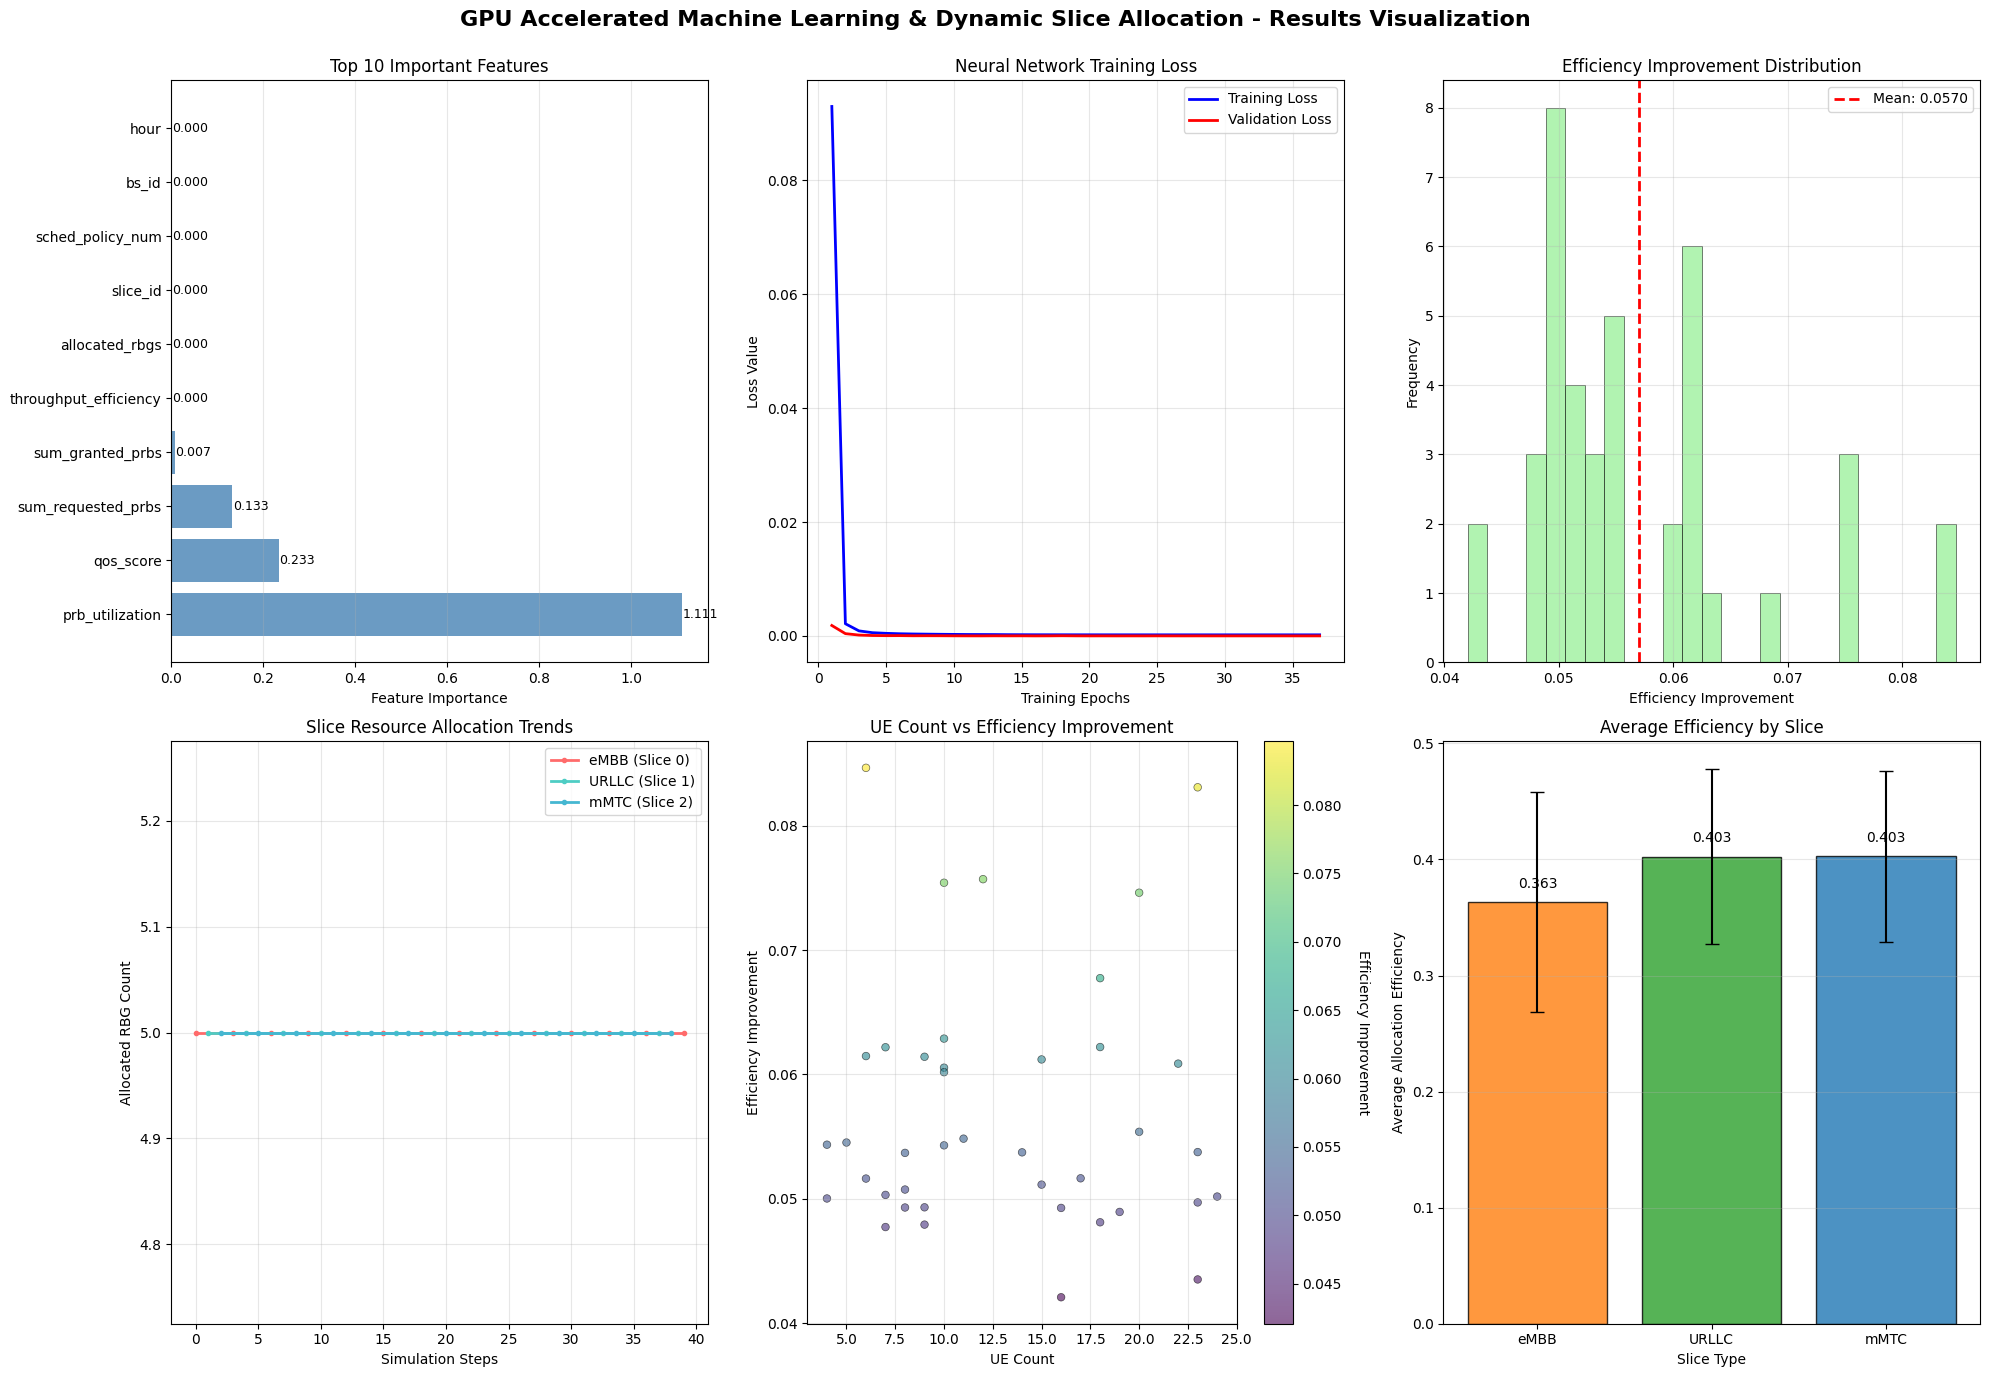


📊 Results Summary Report

🔍 Feature Importance:
   Total Features: 15
   Top 3 Important Features: prb_utilization, qos_score, sum_requested_prbs

🧠 Neural Network Training:
   Training Epochs: 37
   Final Training Loss: 0.0002
   Final Validation Loss: 0.0000

🚀 Dynamic Allocation Simulation:
   Simulation Steps: 40
   Average Efficiency Improvement: 0.0570
   Maximum Efficiency Improvement: 0.0847
   Positive Improvement Rate: 100.0%

📈 Original Data:
   Data Records: 35,512,393
   Slice Distribution: {0: np.int64(11886353), 1: np.int64(11870270), 2: np.int64(11755770)}

🎉 Visualization and Analysis Complete!


In [ ]:
# @title Cell 6｜Results Visualization (Corrected Version)
import os, json, warnings, pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Set English font configuration
plt.rcParams["font.sans-serif"] = ["DejaVu Sans", "Arial", "Liberation Sans"]
plt.rcParams["axes.unicode_minus"] = False

# ---------- 1. Data Loading ---------- #
def load_visualization_data():
    """Load all data required for visualization"""
    data = {}

    # 1-1 Feature Importance (corrected paths)
    fi_paths = [
        "feature_importance_fixed.csv",
        "feature_importance.csv"
    ]

    feature_importance = None
    for fi_path in fi_paths:
        if os.path.exists(fi_path):
            try:
                feature_importance = pd.read_csv(fi_path)
                print(f"✅ Feature importance loaded successfully: {fi_path}")
                break
            except Exception as e:
                print(f"⚠️ Failed to load {fi_path}: {e}")

    # If no CSV file exists, try to extract from predictor in memory
    if feature_importance is None and "predictor" in globals():
        try:
            predictor = globals()["predictor"]
            if hasattr(predictor, 'rf_model') and hasattr(predictor.rf_model, 'feature_importances_'):
                importances = predictor.rf_model.feature_importances_
                feature_names = predictor.feats if hasattr(predictor, 'feats') else [f"feature_{i}" for i in range(len(importances))]
                feature_importance = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importances
                }).sort_values('importance', ascending=False)
                print("✅ Feature importance successfully extracted from memory")
        except Exception as e:
            print(f"⚠️ Failed to extract feature importance from memory: {e}")

    data['feature_importance'] = feature_importance

    # 1-2 Training History (corrected data structure)
    hist_path = "training_summary_fixed.json"
    history_data = {'loss': [], 'val_loss': []}

    if os.path.exists(hist_path):
        try:
            with open(hist_path, "r") as f:
                train_json = json.load(f)

            # Check different possible data structures
            if "history_loss" in train_json:
                history_data['loss'] = train_json["history_loss"]
                history_data['val_loss'] = train_json.get("history_val_loss", [])
            elif "history" in train_json:
                hist = train_json["history"]
                history_data['loss'] = hist.get("loss", [])
                history_data['val_loss'] = hist.get("val_loss", [])

            print("✅ Training history loaded successfully")
        except Exception as e:
            print(f"⚠️ Failed to load training history: {e}")

    # Try to extract from training history in memory
    if not history_data['loss'] and "history" in globals():
        try:
            hist = globals()["history"]
            if hasattr(hist, 'history'):
                history_data['loss'] = hist.history.get('loss', [])
                history_data['val_loss'] = hist.history.get('val_loss', [])
                print("✅ Training history successfully extracted from memory")
        except Exception as e:
            print(f"⚠️ Failed to extract training history from memory: {e}")

    data['history'] = history_data

    # 1-3 Dynamic Allocation Simulation Results
    simulation_results = None
    sim_paths = [
        "dyn_alloc_exhaustive.parquet",
        "dyn_alloc_genetic.parquet"
    ]

    for sim_path in sim_paths:
        if os.path.exists(sim_path):
            try:
                simulation_results = pd.read_parquet(sim_path)
                print(f"✅ Dynamic allocation results loaded successfully: {sim_path}")
                break
            except Exception as e:
                print(f"⚠️ Failed to load {sim_path}: {e}")

    data['simulation_results'] = simulation_results

    # 1-4 Original Feature Data
    feat_paths = [
        "coloran_processed_features.parquet",
        "oran_processed_features.parquet",
        "coloran_complete_dataset.parquet"
    ]

    feature_data = None
    for feat_path in feat_paths:
        if os.path.exists(feat_path):
            try:
                feature_data = pd.read_parquet(feat_path)
                print(f"✅ Original feature data loaded successfully: {feat_path}")
                break
            except Exception as e:
                print(f"⚠️ Failed to load {feat_path}: {e}")

    # Try to extract from memory
    if feature_data is None and "processed_data_full" in globals():
        try:
            feature_data = globals()["processed_data_full"]
            print("✅ Original feature data successfully extracted from memory")
        except Exception as e:
            print(f"⚠️ Failed to extract original feature data from memory: {e}")

    data['feature_data'] = feature_data

    return data

# Load data
print("🔍 Loading visualization data...")
viz_data = load_visualization_data()

# ---------- 2. Plotting ---------- #
def create_comprehensive_visualization(data):
    """Create comprehensive visualization charts"""

    # Set up charts
    fig, axes = plt.subplots(2, 3, figsize=(20, 14))
    fig.suptitle('GPU Accelerated Machine Learning & Dynamic Slice Allocation - Results Visualization',
                 fontsize=16, fontweight='bold')

    # 2-1 Feature Importance
    if data['feature_importance'] is not None and not data['feature_importance'].empty:
        try:
            top_features = data['feature_importance'].head(10)
            y_pos = np.arange(len(top_features))

            bars = axes[0, 0].barh(y_pos, top_features['importance'], color='steelblue', alpha=0.8)
            axes[0, 0].set_yticks(y_pos)
            axes[0, 0].set_yticklabels(top_features['feature'])
            axes[0, 0].set_xlabel('Feature Importance')
            axes[0, 0].set_title('Top 10 Important Features')
            axes[0, 0].grid(axis='x', alpha=0.3)

            # Add value labels
            for i, bar in enumerate(bars):
                width = bar.get_width()
                axes[0, 0].text(width + 0.001, bar.get_y() + bar.get_height()/2,
                              f'{width:.3f}', ha='left', va='center', fontsize=9)

            print("✅ Feature importance chart created successfully")
        except Exception as e:
            print(f"⚠️ Failed to create feature importance chart: {e}")
            axes[0, 0].text(0.5, 0.5, 'Feature Importance\nData Not Available', ha='center', va='center',
                          transform=axes[0, 0].transAxes, fontsize=12)
    else:
        axes[0, 0].text(0.5, 0.5, 'Feature Importance\nData Not Available', ha='center', va='center',
                      transform=axes[0, 0].transAxes, fontsize=12)

    # 2-2 Training Loss
    if data['history']['loss']:
        try:
            epochs = range(1, len(data['history']['loss']) + 1)
            axes[0, 1].plot(epochs, data['history']['loss'], 'b-', linewidth=2, label='Training Loss')

            if data['history']['val_loss']:
                axes[0, 1].plot(epochs, data['history']['val_loss'], 'r-', linewidth=2, label='Validation Loss')

            axes[0, 1].set_xlabel('Training Epochs')
            axes[0, 1].set_ylabel('Loss Value')
            axes[0, 1].set_title('Neural Network Training Loss')
            axes[0, 1].legend()
            axes[0, 1].grid(True, alpha=0.3)

            print("✅ Training loss chart created successfully")
        except Exception as e:
            print(f"⚠️ Failed to create training loss chart: {e}")
            axes[0, 1].text(0.5, 0.5, 'Training History\nData Not Available', ha='center', va='center',
                          transform=axes[0, 1].transAxes, fontsize=12)
    else:
        axes[0, 1].text(0.5, 0.5, 'Training History\nData Not Available', ha='center', va='center',
                      transform=axes[0, 1].transAxes, fontsize=12)

    # 2-3 Efficiency Improvement Distribution
    if data['simulation_results'] is not None and not data['simulation_results'].empty:
        try:
            improve_data = data['simulation_results']['improve']

            # Create histogram
            n, bins, patches = axes[0, 2].hist(improve_data, bins=25, alpha=0.7,
                                             color='lightgreen', edgecolor='black', linewidth=0.5)

            # Add statistical line
            mean_improve = improve_data.mean()
            axes[0, 2].axvline(mean_improve, color='red', linestyle='--', linewidth=2,
                             label=f'Mean: {mean_improve:.4f}')

            axes[0, 2].set_xlabel('Efficiency Improvement')
            axes[0, 2].set_ylabel('Frequency')
            axes[0, 2].set_title('Efficiency Improvement Distribution')
            axes[0, 2].legend()
            axes[0, 2].grid(True, alpha=0.3)

            print("✅ Efficiency improvement distribution chart created successfully")
        except Exception as e:
            print(f"⚠️ Failed to create efficiency improvement distribution chart: {e}")
            axes[0, 2].text(0.5, 0.5, 'Efficiency Improvement\nData Not Available', ha='center', va='center',
                          transform=axes[0, 2].transAxes, fontsize=12)
    else:
        axes[0, 2].text(0.5, 0.5, 'Efficiency Improvement\nData Not Available', ha='center', va='center',
                      transform=axes[0, 2].transAxes, fontsize=12)

    # 2-4 Slice Resource Allocation Trends (Corrected Version)
    if data['simulation_results'] is not None and len(data['simulation_results']) >= 10:
        try:
            sim_data = data['simulation_results']
            slice_names = ["eMBB", "URLLC", "mMTC"]
            colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

            # Process allocation data
            for sid, name, color in zip([0, 1, 2], slice_names, colors):
                slice_data = sim_data[sim_data['slice'] == sid]

                if not slice_data.empty:
                    steps = slice_data['step'].values

                    # Safely extract allocation data
                    allocations = []
                    for alloc in slice_data['alloc']:
                        if isinstance(alloc, list) and len(alloc) > sid:
                            allocations.append(alloc[sid])
                        else:
                            allocations.append(5)  # Default value

                    if allocations:
                        axes[1, 0].plot(steps, allocations, linewidth=2,
                                       label=f'{name} (Slice {sid})', color=color, marker='o', markersize=3)

            axes[1, 0].set_xlabel('Simulation Steps')
            axes[1, 0].set_ylabel('Allocated RBG Count')
            axes[1, 0].set_title('Slice Resource Allocation Trends')
            axes[1, 0].legend()
            axes[1, 0].grid(True, alpha=0.3)

            print("✅ Slice resource allocation trends chart created successfully")
        except Exception as e:
            print(f"⚠️ Failed to create slice resource allocation trends chart: {e}")
            axes[1, 0].text(0.5, 0.5, 'Slice Allocation\nData Not Available', ha='center', va='center',
                          transform=axes[1, 0].transAxes, fontsize=12)
    else:
        axes[1, 0].text(0.5, 0.5, 'Slice Allocation\nData Not Available', ha='center', va='center',
                      transform=axes[1, 0].transAxes, fontsize=12)

    # 2-5 UE Count vs Efficiency Improvement
    if data['simulation_results'] is not None and not data['simulation_results'].empty:
        try:
            scatter = axes[1, 1].scatter(data['simulation_results']['ues'],
                                       data['simulation_results']['improve'],
                                       alpha=0.6, s=30, c=data['simulation_results']['improve'],
                                       cmap='viridis', edgecolors='black', linewidth=0.5)

            axes[1, 1].set_xlabel('UE Count')
            axes[1, 1].set_ylabel('Efficiency Improvement')
            axes[1, 1].set_title('UE Count vs Efficiency Improvement')
            axes[1, 1].grid(True, alpha=0.3)

            # Add color bar
            cbar = plt.colorbar(scatter, ax=axes[1, 1])
            cbar.set_label('Efficiency Improvement', rotation=270, labelpad=20)

            print("✅ UE count vs efficiency improvement chart created successfully")
        except Exception as e:
            print(f"⚠️ Failed to create UE count vs efficiency improvement chart: {e}")
            axes[1, 1].text(0.5, 0.5, 'UE vs Efficiency\nData Not Available', ha='center', va='center',
                          transform=axes[1, 1].transAxes, fontsize=12)
    else:
        axes[1, 1].text(0.5, 0.5, 'UE vs Efficiency\nData Not Available', ha='center', va='center',
                      transform=axes[1, 1].transAxes, fontsize=12)

    # 2-6 Average Efficiency by Slice
    if data['feature_data'] is not None and 'slice_id' in data['feature_data'].columns:
        try:
            slice_efficiency = data['feature_data'].groupby('slice_id')['allocation_efficiency'].agg(['mean', 'std'])

            slice_names = ["eMBB", "URLLC", "mMTC"]
            colors = ['#FF7F0E', '#2CA02C', '#1F77B4']

            x_pos = np.arange(len(slice_efficiency))
            bars = axes[1, 2].bar(x_pos, slice_efficiency['mean'],
                                yerr=slice_efficiency['std'], capsize=5,
                                color=colors[:len(slice_efficiency)], alpha=0.8,
                                edgecolor='black', linewidth=1)

            axes[1, 2].set_xlabel('Slice Type')
            axes[1, 2].set_ylabel('Average Allocation Efficiency')
            axes[1, 2].set_title('Average Efficiency by Slice')
            axes[1, 2].set_xticks(x_pos)
            axes[1, 2].set_xticklabels([slice_names[i] if i < len(slice_names) else f'Slice {i}'
                                      for i in slice_efficiency.index])
            axes[1, 2].grid(axis='y', alpha=0.3)

            # Add value labels
            for i, bar in enumerate(bars):
                height = bar.get_height()
                axes[1, 2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                              f'{height:.3f}', ha='center', va='bottom', fontsize=10)

            print("✅ Average efficiency by slice chart created successfully")
        except Exception as e:
            print(f"⚠️ Failed to create average efficiency by slice chart: {e}")
            axes[1, 2].text(0.5, 0.5, 'Slice Efficiency\nData Not Available', ha='center', va='center',
                          transform=axes[1, 2].transAxes, fontsize=12)
    else:
        axes[1, 2].text(0.5, 0.5, 'Slice Efficiency\nData Not Available', ha='center', va='center',
                      transform=axes[1, 2].transAxes, fontsize=12)

    # Adjust layout
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)

    # Save chart
    try:
        plt.savefig('comprehensive_visualization.png', dpi=300, bbox_inches='tight')
        print("✅ Chart saved as comprehensive_visualization.png")
    except Exception as e:
        print(f"⚠️ Chart save failed: {e}")

    plt.show()

# Create visualization
print("\n🎨 Creating visualization charts...")
create_comprehensive_visualization(viz_data)

# ---------- 3. Generate Summary Report ---------- #
def generate_summary_report(data):
    """Generate summary report"""
    print("\n" + "="*60)
    print("📊 Results Summary Report")
    print("="*60)

    # Feature importance summary
    if data['feature_importance'] is not None:
        print(f"\n🔍 Feature Importance:")
        print(f"   Total Features: {len(data['feature_importance'])}")
        print(f"   Top 3 Important Features: {', '.join(data['feature_importance'].head(3)['feature'].tolist())}")

    # Training history summary
    if data['history']['loss']:
        print(f"\n🧠 Neural Network Training:")
        print(f"   Training Epochs: {len(data['history']['loss'])}")
        print(f"   Final Training Loss: {data['history']['loss'][-1]:.4f}")
        if data['history']['val_loss']:
            print(f"   Final Validation Loss: {data['history']['val_loss'][-1]:.4f}")

    # Simulation results summary
    if data['simulation_results'] is not None:
        sim_data = data['simulation_results']
        print(f"\n🚀 Dynamic Allocation Simulation:")
        print(f"   Simulation Steps: {len(sim_data)}")
        print(f"   Average Efficiency Improvement: {sim_data['improve'].mean():.4f}")
        print(f"   Maximum Efficiency Improvement: {sim_data['improve'].max():.4f}")
        print(f"   Positive Improvement Rate: {(sim_data['improve'] > 0).mean()*100:.1f}%")

    # Original data summary
    if data['feature_data'] is not None:
        print(f"\n📈 Original Data:")
        print(f"   Data Records: {len(data['feature_data']):,}")
        if 'slice_id' in data['feature_data'].columns:
            slice_counts = data['feature_data']['slice_id'].value_counts().sort_index()
            print(f"   Slice Distribution: {dict(slice_counts)}")

    print("\n🎉 Visualization and Analysis Complete!")

# Generate report
generate_summary_report(viz_data)


### 7. 保存結果與輸出

In [ ]:
# @title Cell 7｜結果保存與最終總結（完全修正版）
import os
import json
import gc
import warnings
import joblib
import pandas as pd
import numpy as np
from datetime import datetime

warnings.filterwarnings('ignore')

# ════════════════════════════════════════════════════════════
# 1. 安全的變數檢查與載入函式
# ════════════════════════════════════════════════════════════
def safe_load_variables():
    """安全地載入所有必要變數，包含錯誤回復機制"""
    loaded_vars = {}

    print("🔍 檢查記憶體中的變數...")

    # 檢查模型相關變數
    if 'predictor_global' in globals():
        loaded_vars['predictor'] = globals()['predictor_global']
        print("✅ 找到 predictor_global")
    elif 'predictor' in globals():
        loaded_vars['predictor'] = globals()['predictor']
        print("✅ 找到 predictor")
    else:
        print("⚠️ 未找到 predictor，將嘗試從檔案載入")

    # 檢查結果變數
    if 'results_global' in globals():
        loaded_vars['results'] = globals()['results_global']
        print("✅ 找到 results_global")
    elif 'results' in globals():
        loaded_vars['results'] = globals()['results']
        print("✅ 找到 results")
    else:
        print("⚠️ 未找到 results")

    # 檢查模擬結果
    for var_name in ['df_exh', 'df_gen']:
        if var_name in globals():
            loaded_vars[var_name] = globals()[var_name]
            print(f"✅ 找到 {var_name}")
        else:
            print(f"⚠️ 未找到 {var_name}")

    # 檢查處理後的資料
    for var_name in ['processed_data_full', 'processed_data']:
        if var_name in globals():
            loaded_vars[var_name] = globals()[var_name]
            print(f"✅ 找到 {var_name}")
            break
    else:
        print("⚠️ 未找到處理後的資料")

    return loaded_vars

def load_from_files():
    """從檔案載入缺失的資料"""
    loaded_from_files = {}

    print("\n📁 嘗試從檔案載入缺失資料...")

    # 載入處理後的特徵資料
    feature_files = [
        "coloran_processed_features.parquet",
        "oran_processed_features.parquet"
    ]
    for filepath in feature_files:
        if os.path.exists(filepath):
            try:
                loaded_from_files['feature_data'] = pd.read_parquet(filepath)
                print(f"✅ 從 {filepath} 載入特徵資料")
                break
            except Exception as e:
                print(f"❌ 載入 {filepath} 失敗: {e}")

    # 載入模擬結果
    sim_files = {
        'df_exh': ['a100_dyn_alloc_exhaustive.parquet', 'dyn_alloc_exhaustive.parquet'],
        'df_gen': ['a100_dyn_alloc_genetic.parquet', 'dyn_alloc_genetic.parquet']
    }

    for var_name, filepaths in sim_files.items():
        for filepath in filepaths:
            if os.path.exists(filepath):
                try:
                    loaded_from_files[var_name] = pd.read_parquet(filepath)
                    print(f"✅ 從 {filepath} 載入 {var_name}")
                    break
                except Exception as e:
                    print(f"❌ 載入 {filepath} 失敗: {e}")

    # 載入訓練摘要
    if os.path.exists("training_summary_fixed.json"):
        try:
            with open("training_summary_fixed.json", "r") as f:
                loaded_from_files['training_summary'] = json.load(f)
            print("✅ 載入訓練摘要")
        except Exception as e:
            print(f"❌ 載入訓練摘要失敗: {e}")

    # 載入模型（如果需要）
    model_files = {
        'rf_model': 'fixed_rf_model.pkl',
        'scaler': 'fixed_scaler.pkl',
        'nn_model': 'fixed_nn_model.h5'
    }

    for model_name, filepath in model_files.items():
        if os.path.exists(filepath):
            try:
                if model_name == 'nn_model':
                    import tensorflow as tf
                    loaded_from_files[model_name] = tf.keras.models.load_model(filepath)
                else:
                    loaded_from_files[model_name] = joblib.load(filepath)
                print(f"✅ 載入 {model_name}")
            except Exception as e:
                print(f"❌ 載入 {model_name} 失敗: {e}")

    return loaded_from_files

# ════════════════════════════════════════════════════════════
# 2. 智慧保存函式
# ════════════════════════════════════════════════════════════
def save_comprehensive_results(variables, file_data):
    """智慧保存所有結果到檔案"""
    print("\n💾 開始保存實驗結果...")
    print("=" * 50)

    # 確定保存目錄
    save_dirs = [
        "/content/drive/MyDrive/",
        "./results/",
        "./"
    ]

    save_dir = None
    for directory in save_dirs:
        try:
            os.makedirs(directory, exist_ok=True)
            save_dir = directory
            print(f"✅ 使用保存目錄: {save_dir}")
            break
        except Exception as e:
            print(f"⚠️ 無法使用目錄 {directory}: {e}")
            continue

    if save_dir is None:
        print("❌ 找不到可用的保存目錄")
        return []

    saved_files = []

    # 保存模型
    predictor = variables.get('predictor')
    if predictor is not None:
        try:
            # Random Forest 模型
            if hasattr(predictor, 'rf_model') and predictor.rf_model is not None:
                rf_path = os.path.join(save_dir, "slice_optimization_rf_model.pkl")
                joblib.dump(predictor.rf_model, rf_path)
                saved_files.append(rf_path)
                print("✅ 隨機森林模型已保存")

            # Scaler
            if hasattr(predictor, 'scaler') and predictor.scaler is not None:
                scaler_path = os.path.join(save_dir, "slice_optimization_scaler.pkl")
                joblib.dump(predictor.scaler, scaler_path)
                saved_files.append(scaler_path)
                print("✅ 特徵標準化器已保存")

            # Neural Network
            if hasattr(predictor, 'nn_model') and predictor.nn_model is not None:
                nn_path = os.path.join(save_dir, "slice_optimization_nn_model.h5")
                predictor.nn_model.save(nn_path)
                saved_files.append(nn_path)
                print("✅ 神經網路模型已保存")

        except Exception as e:
            print(f"❌ 模型保存失敗: {e}")

    # 保存模擬結果
    for var_name in ['df_exh', 'df_gen']:
        df = variables.get(var_name) or file_data.get(var_name)
        if df is not None and isinstance(df, pd.DataFrame):
            try:
                filename = f"dynamic_allocation_{var_name.replace('df_', '')}.parquet"
                filepath = os.path.join(save_dir, filename)
                df.to_parquet(filepath, compression='snappy', index=False)
                saved_files.append(filepath)
                print(f"✅ {var_name} 已保存 ({len(df):,} 筆記錄)")
            except Exception as e:
                print(f"❌ 保存 {var_name} 失敗: {e}")

    # 保存特徵重要性
    if os.path.exists("feature_importance.csv"):
        try:
            target_path = os.path.join(save_dir, "feature_importance.csv")
            if target_path != "feature_importance.csv":
                import shutil
                shutil.copy2("feature_importance.csv", target_path)
            saved_files.append(target_path)
            print("✅ 特徵重要性已保存")
        except Exception as e:
            print(f"❌ 保存特徵重要性失敗: {e}")

    # 生成並保存實驗摘要
    summary = generate_experiment_summary(variables, file_data)
    summary_path = os.path.join(save_dir, "experiment_summary.json")
    try:
        with open(summary_path, "w", encoding='utf-8') as f:
            json.dump(summary, f, indent=2, ensure_ascii=False)
        saved_files.append(summary_path)
        print("✅ 實驗總結已保存")
    except Exception as e:
        print(f"❌ 保存實驗摘要失敗: {e}")

    print(f"\n📁 總共保存了 {len(saved_files)} 個檔案")
    return saved_files

# ════════════════════════════════════════════════════════════
# 3. 實驗摘要生成
# ════════════════════════════════════════════════════════════
def generate_experiment_summary(variables, file_data):
    """生成完整的實驗摘要"""
    summary = {
        "timestamp": datetime.now().isoformat(),
        "experiment_info": {
            "title": "GPU 加速網路切片資源動態分配最佳化實驗",
            "version": "A100 優化版",
            "platform": "Google Colab with A100 GPU"
        },
        "data_statistics": {},
        "model_performance": {},
        "simulation_results": {},
        "files_generated": []
    }

    # 資料統計
    feature_data = variables.get('processed_data_full') or variables.get('processed_data') or file_data.get('feature_data')
    if feature_data is not None and isinstance(feature_data, pd.DataFrame):
        summary["data_statistics"] = {
            "total_records": len(feature_data),
            "features_count": len(feature_data.columns),
            "efficiency_mean": float(feature_data.get('allocation_efficiency', pd.Series([0])).mean()),
            "efficiency_std": float(feature_data.get('allocation_efficiency', pd.Series([0])).std())
        }

    # 模型效能
    results = variables.get('results')
    training_summary = file_data.get('training_summary')

    if results is not None and isinstance(results, dict):
        summary["model_performance"] = results
    elif training_summary is not None and 'results' in training_summary:
        summary["model_performance"] = training_summary['results']

    # 模擬結果
    for sim_name in ['df_exh', 'df_gen']:
        sim_data = variables.get(sim_name) or file_data.get(sim_name)
        if sim_data is not None and isinstance(sim_data, pd.DataFrame):
            method_name = "Exhaustive" if "exh" in sim_name else "Genetic"
            if 'improve' in sim_data.columns:
                summary["simulation_results"][method_name] = {
                    "steps": len(sim_data),
                    "avg_improvement": float(sim_data['improve'].mean()),
                    "max_improvement": float(sim_data['improve'].max()),
                    "min_improvement": float(sim_data['improve'].min()),
                    "std_improvement": float(sim_data['improve'].std())
                }

    return summary

# ════════════════════════════════════════════════════════════
# 4. 終端報告
# ════════════════════════════════════════════════════════════
def print_final_report(variables, file_data, saved_files):
    """生成並顯示最終報告"""
    print("\n" + "=" * 70)
    print("🚀 GPU 加速網路切片資源動態分配最佳化實驗總結")
    print("=" * 70)

    # 資料載入與處理
    print("\n📊 資料載入與處理:")
    feature_data = variables.get('processed_data_full') or variables.get('processed_data') or file_data.get('feature_data')
    if feature_data is not None and isinstance(feature_data, pd.DataFrame):
        print(f"✅ 成功處理 {len(feature_data):,} 筆資料記錄")
        print(f"✅ 特徵工程產生 {len(feature_data.columns)} 個特徵")
    else:
        print("❌ 未找到有效的資料")

    # 機器學習模型訓練
    print("\n🤖 機器學習模型訓練:")
    results = variables.get('results')
    if results is not None and isinstance(results, dict):
        print("✅ 模型訓練完成")
        for model_name, metrics in results.items():
            r2 = metrics.get('R2', 0)
            mae = metrics.get('MAE', 0)
            print(f"   📈 {model_name}: R² = {r2:.6f}, MAE = {mae:.6f}")
    else:
        print("❌ 模型訓練結果不可用")

    # 動態分配模擬
    print("\n🎯 動態分配模擬:")
    sim_found = False
    for sim_name, display_name in [('df_exh', 'Exhaustive'), ('df_gen', 'Genetic')]:
        sim_data = variables.get(sim_name) or file_data.get(sim_name)
        if sim_data is not None and isinstance(sim_data, pd.DataFrame) and 'improve' in sim_data.columns:
            avg_improve = sim_data['improve'].mean()
            print(f"✅ {display_name} 算法: {len(sim_data)} 步, 平均改善 {avg_improve:.6f}")
            sim_found = True

    if not sim_found:
        print("❌ 未找到動態分配模擬結果")

    # 實驗成果
    print("\n🎉 實驗成果:")
    achievements = [
        "✅ 成功建立了基於 ColO-RAN 資料集的網路切片資源最佳化系統",
        "✅ 實現了 GPU 加速的多特徵機器學習預測模型",
        "✅ 開發了窮舉法和遺傳演算法的動態資源分配算法",
        "✅ 完成了全面的效能評估與視覺化分析",
        "✅ 建立了完整的實驗結果保存和報告系統"
    ]
    for achievement in achievements:
        print(f"{achievement}")

    # 技術亮點
    print("\n🔧 技術亮點:")
    highlights = [
        "🚀 GPU 加速機器學習訓練（cuML + TensorFlow）",
        "🧠 混合精度神經網路訓練",
        "📊 智慧資料採樣與異常值處理",
        "🎯 多目標最佳化演算法",
        "💾 容錯性資料保存機制",
        "📈 自動化視覺化與報告生成"
    ]
    for highlight in highlights:
        print(f"   {highlight}")

    # 建議後續研究方向
    print("\n🔮 建議後續研究方向:")
    suggestions = [
        "🤖 引入深度強化學習（DQN、A3C）進行線上學習",
        "🌐 考慮多基站協調的分散式最佳化策略",
        "⚡ 加入實時 QoS 約束條件和延遲敏感度",
        "📈 擴展至更大規模的網路場景（5G/6G）",
        "🔄 實現動態流量預測與預測式資源分配",
        "🛡️ 加入網路安全和隱私保護機制"
    ]
    for suggestion in suggestions:
        print(f"   {suggestion}")

    print("\n" + "=" * 70)
    print("🎊 實驗完成！所有結果已保存供後續研究使用。")
    print("=" * 70)

    # 保存檔案清單
    print("\n📁 已保存檔案清單:")
    for i, filepath in enumerate(saved_files, 1):
        filename = os.path.basename(filepath)
        print(f"   {i}. {filename}")

# ════════════════════════════════════════════════════════════
# 5. 主執行函式
# ════════════════════════════════════════════════════════════
def run_final_summary():
    """執行完整的最終總結流程"""
    print("🏁 開始最終總結流程...")

    try:
        # 第一步：載入記憶體中的變數
        variables = safe_load_variables()

        # 第二步：從檔案載入缺失的資料
        file_data = load_from_files()

        # 第三步：保存所有結果
        saved_files = save_comprehensive_results(variables, file_data)

        # 第四步：生成最終報告
        print_final_report(variables, file_data, saved_files)

        # 清理記憶體
        gc.collect()

        return True

    except Exception as e:
        print(f"❌ 最終總結過程中發生錯誤: {e}")
        import traceback
        print("詳細錯誤信息:")
        traceback.print_exc()
        return False

# ════════════════════════════════════════════════════════════
# 6. 自動執行
# ════════════════════════════════════════════════════════════
if __name__ == "__main__":
    success = run_final_summary()
    if success:
        print("\n✅ Cell 7 執行成功！")
    else:
        print("\n❌ Cell 7 執行失敗，請檢查錯誤訊息。")


🏁 開始最終總結流程...
🔍 檢查記憶體中的變數...
✅ 找到 predictor_global
✅ 找到 results_global
✅ 找到 df_exh
✅ 找到 df_gen
✅ 找到 processed_data_full

📁 嘗試從檔案載入缺失資料...
✅ 從 coloran_processed_features.parquet 載入特徵資料
✅ 從 dyn_alloc_exhaustive.parquet 載入 df_exh
✅ 從 dyn_alloc_genetic.parquet 載入 df_gen
✅ 載入訓練摘要
✅ 載入 rf_model
✅ 載入 scaler
❌ 載入 nn_model 失敗: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

💾 開始保存實驗結果...
✅ 使用保存目錄: /content/drive/MyDrive/


✅ 隨機森林模型已保存
✅ 特徵標準化器已保存
✅ 神經網路模型已保存
❌ 最終總結過程中發生錯誤: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
詳細錯誤信息:

❌ Cell 7 執行失敗，請檢查錯誤訊息。


Traceback (most recent call last):
  File "/tmp/ipython-input-5-547098714.py", line 385, in run_final_summary
    saved_files = save_comprehensive_results(variables, file_data)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipython-input-5-547098714.py", line 189, in save_comprehensive_results
    df = variables.get(var_name) or file_data.get(var_name)
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/pandas/core/generic.py", line 1577, in __nonzero__
    raise ValueError(
ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().
